In [1]:
import sys
sys.path.append("/global/scratch/users/pfromm/ani-project")

import numpy as np
import torch

import matplotlib.pyplot as plt
import pickle

from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from torch import nn


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [142]:
with open('aevs.pkl', 'rb') as f:
    AEVS, Energy, Species = pickle.load(f)
    

In [144]:
def split_data_numpy(X_data, Y_data, species_list):
    # Generate indices for the molecules
    indices = list(range(len(Y_data)))

    # Split indices into training, validation, and test sets
    train_indices, val_indices = train_test_split(indices, test_size=1/3, random_state=42)

    # Function to split data based on indices
    def subset_data(data, indices):
        return [data[i] for i in indices]

    # Split X_data, Y_data, and species_list
    train_X = subset_data(X_data, train_indices)
    train_Y = subset_data(Y_data, train_indices)
    train_species = subset_data(species_list, train_indices)

    val_X = subset_data(X_data, val_indices)
    val_Y = subset_data(Y_data, val_indices)
    val_species = subset_data(species_list, val_indices)

    return train_X, train_Y, train_species, val_X, val_Y, val_species
    #return train_Y, train_species, val_Y, val_species, test_Y, test_species

In [145]:
train_X, train_Y, train_species, val_X, val_Y, val_species = split_data_numpy(AEVS, Energy, Species)

In [ ]:
# Coded used to make the data file pca_exp, consisting of 5 sets of data for train and validation each with a different 
# number of PCA componets- Does not need to be ran, can import file

flattened_train = []
original_shape_train = []

for array in train_X:
    # Store the original shape
    original_shape_train.append(array.shape)
    
    # Flatten the array to 2D (shape[0]*shape[1], shape[2]) and store it
    flattened_array = array.reshape(-1, array.shape[2])
    flattened_train.append(flattened_array)
flattened_train = np.vstack(flattened_train)


flattened_val = []
original_shape_val = []
for array in val_X:
    # Store the original shape
    original_shape_val.append(array.shape)
    
    # Flatten the array to 2D (shape[0]*shape[1], shape[2]) and store it
    flattened_array = array.reshape(-1, array.shape[2])
    flattened_val.append(flattened_array)
flattened_val = np.vstack(flattened_val)

sizes= [0.99, 0.95, 0.90, 0.85, 0.80]
ncomponets=[]
pca_train =[]
scaler = StandardScaler()
scaled_train = scaler.fit_transform(flattened_train)

for size in sizes:
    pca = PCA(n_components=size)
    pca_training= pca.fit_transform(scaled_train)
    num_features= pca.n_components_
    pca_train.append(pca_training)
    ncomponets.append(num_features)
    
pca_val =[]
scaler = StandardScaler()
scaled_val = scaler.fit_transform(flattened_val)

for size in ncomponets:
    pca = PCA(n_components=size)
    pca_validation= pca.fit_transform(scaled_val)
    pca_val.append(pca_validation)


recon_train = []

for i in range(len(sizes)):
    temp = []
    start = 0
    for shape in original_shape_train:
        # Calculate the number of elements in this flattened array
        size = shape[0] * shape[1]

        # Slice the combined array and reshape it back to the original 3D shape
        recon_training = pca_train[i][start:start + size].reshape(shape[0], shape[1], ncomponets[i])
        temp.append(recon_training)

        # Update the start index for the next array
        start += size
    recon_train.append(temp)
    

    
recon_val = []

for i in range(len(sizes)):
    temp = []
    start = 0
    for shape in original_shape_val:
        # Calculate the number of elements in this flattened array
        size = shape[0] * shape[1]

        # Slice the combined array and reshape it back to the original 3D shape
        recon_validate = pca_val[i][start:start + size].reshape(shape[0], shape[1], ncomponets[i])
        temp.append(recon_validate)

        # Update the start index for the next array
        start += size
    recon_val.append(temp)

with open('pca_exp.pkl', 'wb') as f:
    pickle.dump((recon_train, recon_val, ncomponets), f)

In [30]:
def convert_to_tensors(data, indices):
        return [torch.tensor(data[i], dtype=torch.float).unsqueeze(1) for i in indices]

In [29]:
tensor_train = convert_to_tensors(train, range(len(train)))
tensor_val = convert_to_tensors(val, range(len(val)))


In [32]:
tensor_Ytrain= convert_to_tensors(train_Y, range(len(train_Y)))
tensor_Yval= convert_to_tensors(val_Y, range(len(val_Y)))

In [33]:
with open('pca_data_124.pkl', 'wb') as f:
    pickle.dump((tensor_train, tensor_Ytrain, train_species, tensor_val, tensor_Yval, val_species), f)

In [2]:
with open('pca_data_124.pkl', 'rb') as f:
    train_X, train_Y, train_species, val_X, val_Y, val_species = pickle.load(f)

## Start of Modeling

### Hyper Parameter Tuning

In [4]:
import math 
class ANI(nn.Module):
    def __init__(self, num_features):
        super(ANI, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub(num_features), "H": ANI_sub(num_features),
                                    "O": ANI_sub(num_features), "N": ANI_sub(num_features)})

    def forward(self, aevs, atom_types):
        # assuming aevs are being inserted in size (batch size, number of atoms, 384)
        atomic_energies=[]
        i = 0
        for atom in atom_types:
            aev=aevs[:,i,:].unsqueeze(1)
            energy = self.sub_nets[atom](aev)
            atomic_energies.append(energy)
            i=i+1
        energies = torch.cat(atomic_energies, dim =1)
        total_energies = torch.sum(energies, dim=1)
        return total_energies


class ANI_sub(nn.Module):
    def __init__(self, num_features):
        super(ANI_sub, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(num_features, math.ceil(num_features /6)),
            nn.CELU(alpha=0.1),
            nn.Linear(math.ceil(num_features /6),math.ceil(num_features /6)),
            nn.CELU(alpha=0.1),
            nn.Linear(math.ceil(num_features /6),math.ceil(math.ceil(num_features /6)/2)),
            nn.CELU(alpha=0.1),
            nn.Linear(math.ceil(math.ceil(num_features /6)/2),1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)

        return atomic_energy

Testing which size is better. Had to come up with an approach for how to know what size is best as I dont think it would have been the ebst to jsut choose one model (I actually did this initally in an other notebook, i chose one that was of this format for 32, and 64 as the second layer in put and I got the same results, which ill discuss in a second)

In [12]:
def validate(model, val_X):
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='mean')
    total_mse = 0.0
    count = 0
    model.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = Y_val[i].to(device)
            predicted_energies = model(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
#             count += predicted_energies.shape[0]
    model.train(True)
    return math.sqrt(total_mse/len(val_X) )

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD

end_train_loss=[]
end_val_loss=[]

j=0
for size in ncomponets:
    model=ANI(size)
    AdamW=torch.optim.AdamW(model.parameters())
    #SGD= torch.optim.SGD(model.parameters(), lr=1e-5)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    #SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='sum')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 10
    early_stopping_learning_rate = 1.0E-7
    train_X=tensor_train[j]
    val_X = tensor_val[j]
    j+=1
    for epoch in range(max_epochs):
        rmse = validate(model, val_X)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        #SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = train_species[i]
            coordinates = train_X[i].to(device)
            true_energies = Y_train[i].to(device)
            #num_atoms = sum(1 for atom in species if atom != "H")
            num_atoms = len(species)
            num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = mse(predicted_energies, true_energies).mean()
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            #SGD.zero_grad()
            loss.backward()
            AdamW.step()
            #SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(train_X))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)

training starting from epoch 1
RMSE: 158.36193274356145 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]


RMSE: 154.07735365855225 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]


RMSE: 135.18557165188898 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]


RMSE: 51.0039881797523 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]


RMSE: 47.93826158422051 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]


RMSE: 41.986864351921895 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 41.75582951988048 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]


RMSE: 42.070192515025916 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]


RMSE: 41.90778173885418 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 41.147392347246075 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]


training starting from epoch 1
RMSE: 156.53336273109585 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 152.39612772379084 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 138.84516581158726 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 91.99855208482607 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 56.08092637706734 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 50.81629491005603 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]


RMSE: 48.98630023948882 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]


RMSE: 47.93461758469609 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 47.24039715593572 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 46.67090734952061 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


training starting from epoch 1
RMSE: 156.03363649047523 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]


RMSE: 153.46854948467583 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]


RMSE: 147.38622059148364 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]


RMSE: 126.81964840754117 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]


RMSE: 83.20833844251877 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]


RMSE: 75.07834729731988 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]


RMSE: 72.0864725678527 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]


RMSE: 71.29424008405657 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]


RMSE: 70.42248459671072 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]


RMSE: 69.72353593358596 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]


training starting from epoch 1
RMSE: 157.3090481856301 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]


RMSE: 155.2035565841999 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]


RMSE: 150.9033267003513 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]


RMSE: 139.92220366313362 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]


RMSE: 111.7072751427776 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]


RMSE: 64.55930843990159 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]


RMSE: 50.417164685784364 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]


RMSE: 48.126219669816365 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]


RMSE: 46.2800969359599 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]


RMSE: 44.74976546234309 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:15<00:00,  2.78it/s]


training starting from epoch 1
RMSE: 156.57015268903643 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:15<00:00,  2.78it/s]


RMSE: 154.45242465037566 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]


RMSE: 150.804024974202 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:14<00:00,  2.84it/s]


RMSE: 143.27668902135184 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:14<00:00,  2.85it/s]


RMSE: 127.62906928610626 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]


RMSE: 100.37095214885588 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:14<00:00,  2.94it/s]


RMSE: 75.59587280958279 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]


RMSE: 72.38055486290703 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:14<00:00,  2.95it/s]


RMSE: 69.8758045075154 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:14<00:00,  2.90it/s]


RMSE: 68.0665028451712 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:14<00:00,  2.84it/s]


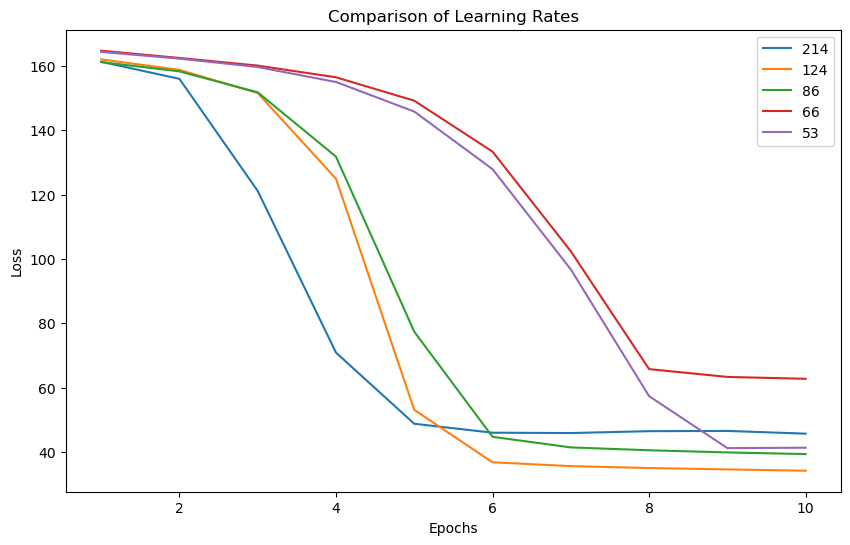

In [20]:
epochs = range(1, 11)
size = [ '214', '124', '86', '66', '53']
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(epochs, end_val_loss[i], label=size[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Learning Rates')
plt.legend()
plt.show()

Looks like maybe 124, but then again on second glance, its values ended up reaching na with these leaarning rates.

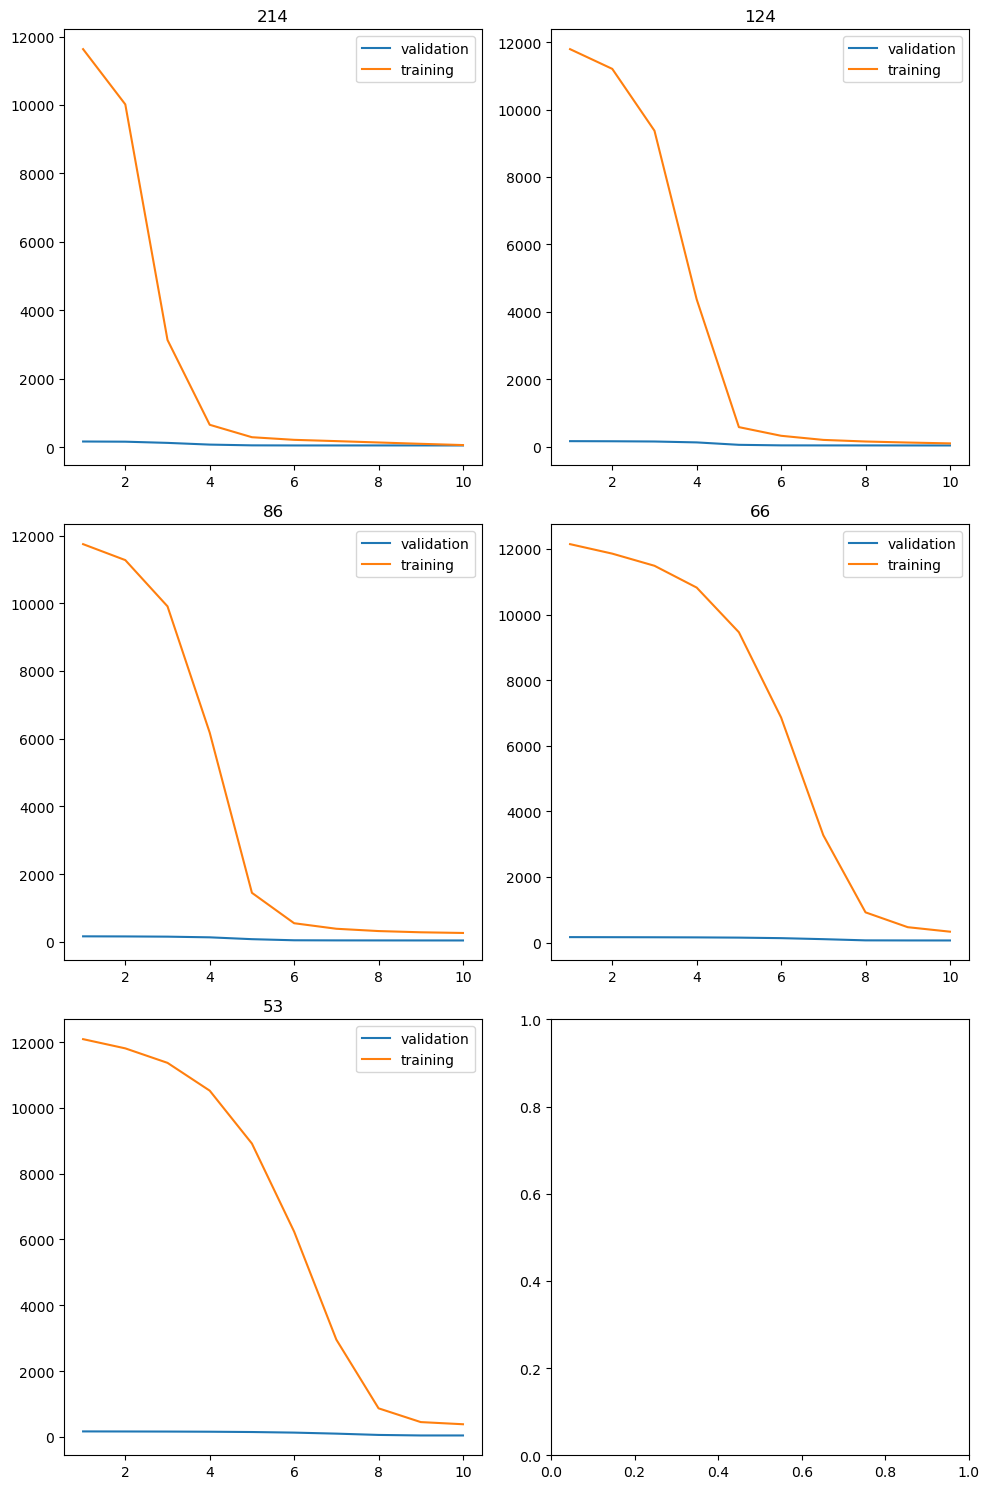

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns

k=0
for i in range(3):
    for j in range(2):
        if k ==5:
            break
        axs[i, j].plot(epochs, end_val_loss[k], label="validation")
        axs[i, j].plot(epochs, end_train_loss[k], label="training")
        axs[i, j].legend()
        axs[i, j].set_title(size[k])
        k+=1

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

124 or 86, the training loss is much worst then the validation loss. Its weird that we would have such low loss for our validation set i think this is due to how the loss is being calucated by normallizing by the squaree root of the number of atoms in the molecule ( id dint know this at this time but i acctually do not like that method of calcualting loss and will change it)

Choosing 124, as with these parameters as lr = 1e-4 seems to be pretty promising, if we end up getting nan values for this also, we can re tune learnig rate.

In [25]:
val_X=tensor_val[1]
train_X=tensor_train[1]

def validate(model):
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = Y_val[i].to(device)
            predicted_energies = model(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD
rates = [1e-5,1e-4, 1e-3,1e-2, 1e-1]

end_train_loss=[]
end_val_loss=[]

for rate in rates:
    model=ANI(124)
    AdamW=torch.optim.AdamW(model.parameters(), lr=rate)
    #SGD= torch.optim.SGD(model.parameters(), lr=rate)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='none')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 10
    early_stopping_learning_rate = 1.0E-5

    for epoch in range(max_epochs):
        rmse = validate(model)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        i=0
        for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = train_species[i]
            coordinates = train_X[i].to(device)
            true_energies = Y_train[i].to(device)
            #num_atoms = sum(1 for atom in species if atom != "H")
            num_atoms= len(species)
            num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            #SGD.zero_grad()
            loss.backward()
            AdamW.step()
            #SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(train_X))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)


training starting from epoch 1
RMSE: 163.56297607187574 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


RMSE: 163.53623312497842 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 163.50930265009143 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]


RMSE: 163.48197413109116 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 163.45432602812852 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 163.42638246570385 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 163.3981468026592 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 163.36961694392974 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 163.3407912773932 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 163.31166257480356 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


training starting from epoch 1
RMSE: 159.99279989778776 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]


RMSE: 159.7610751076077 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 159.52190712245869 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 159.2625859139642 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 158.9736349580719 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 158.64434705965317 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 158.2620539528836 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 157.81180293883284 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 157.27549199725465 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 156.63067169692934 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


training starting from epoch 1
RMSE: 160.402385849718 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 155.76354716241067 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 140.21795700420031 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 80.28535158137446 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 48.40236911779191 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 42.77318684581389 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 42.48914860640405 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 42.58124400987557 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 42.44276148652056 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 42.12553276405034 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


training starting from epoch 1
RMSE: 163.45555331040106 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 39.66973471976617 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 29.312695310503535 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 35.88138323958289 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 53.353168134852716 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 57.10579124989268 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 31.587782415490842 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 39.76450334722904 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 103.38192891941205 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 115.66156226926282 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


training starting from epoch 1
RMSE: 164.58448847455102 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: 67.45707729554688 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]


RMSE: 63.82178079387348 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]


RMSE: 74.64488944274548 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]


RMSE: 79.2306057333613 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]


RMSE: 80.41083416284481 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]


RMSE: 98.94717252799705 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


RMSE: 103.83703438451091 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]


RMSE: 97.58509268099247 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]


RMSE: 103.0023650789489 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


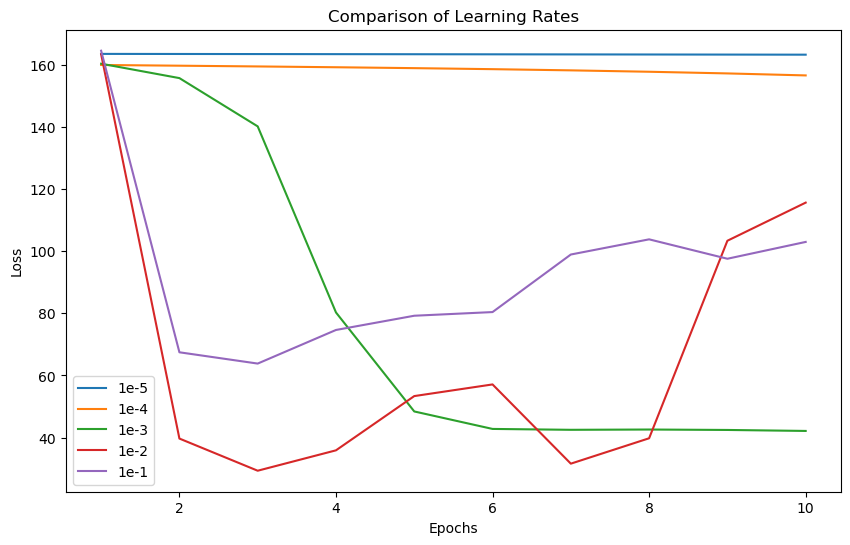

In [26]:
epochs = range(1, 11)
rates = [ '1e-5','1e-4', '1e-3', '1e-2', '1e-1']
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(epochs, end_val_loss[i], label=rates[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Learning Rates')
plt.legend()
plt.show()

Yeah only one that really makes sense is 1e-3. I still tested however because when running oreviosly with thw sgd and adam togethe ri was getting na so i was thinking maybe we just use adama nd find a better rate, however none of these seem like a btter choice. Lets tests for SGD learing rate now.

In [27]:
val_X=tensor_val[1]
train_X=tensor_train[1]

def validate(model):
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = Y_val[i].to(device)
            predicted_energies = model(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD
rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

end_train_loss=[]
end_val_loss=[]

for rate in rates:
    model=ANI(124)
    AdamW=torch.optim.AdamW(model.parameters())
    SGD= torch.optim.SGD(model.parameters(), lr=rate)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='none')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 10
    early_stopping_learning_rate = 1.0E-5

    for epoch in range(max_epochs):
        rmse = validate(model)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        i=0
        for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = train_species[i]
            coordinates = train_X[i].to(device)
            true_energies = Y_train[i].to(device)
            #num_atoms = sum(1 for atom in species if atom != "H")
            num_atoms= len(species)
            num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            SGD.zero_grad()
            loss.backward()
            AdamW.step()
            SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(train_X))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)


training starting from epoch 1
RMSE: 164.98522927511044 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]


RMSE: 162.0631774145315 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 157.2163003560367 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 135.4219168008379 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 46.679546036852024 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 36.80580155562913 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]


RMSE: 36.5096236055718 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 36.482421480238244 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 36.25592291962866 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 35.96564126791303 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


training starting from epoch 1
RMSE: 160.303148396854 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 142.19401634034563 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 103.04493620256935 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 91.88703812482055 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 77.33029617498958 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 76.410645717534 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]


RMSE: 74.82120223515717 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 72.06048000092797 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]


RMSE: 68.96674564031709 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]


RMSE: 65.76659422082938 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


training starting from epoch 1
RMSE: 160.3688498828312 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 142.37528321380202 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 97.96096327967321 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]


RMSE: 99.07298356811276 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]


RMSE: 115.0068663659912 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]


RMSE: 100.08834569753178 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 83.77008557133422 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]


RMSE: 82.85664197296899 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: 74.14889499742898 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]


RMSE: 61.081123293865254 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]


training starting from epoch 1
RMSE: 163.9079624101683 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: nan at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: nan at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: nan at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: nan at epoch 5


epoch 5: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]


RMSE: nan at epoch 6


epoch 6: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]


RMSE: nan at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: nan at epoch 8


epoch 8: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: nan at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]


RMSE: nan at epoch 10


epoch 10: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]


training starting from epoch 1
RMSE: 164.88919715728846 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: nan at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: nan at epoch 3


epoch 3: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: nan at epoch 4


epoch 4: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: nan at epoch 5


epoch 5: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: nan at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: nan at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: nan at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: nan at epoch 9


epoch 9: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: nan at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


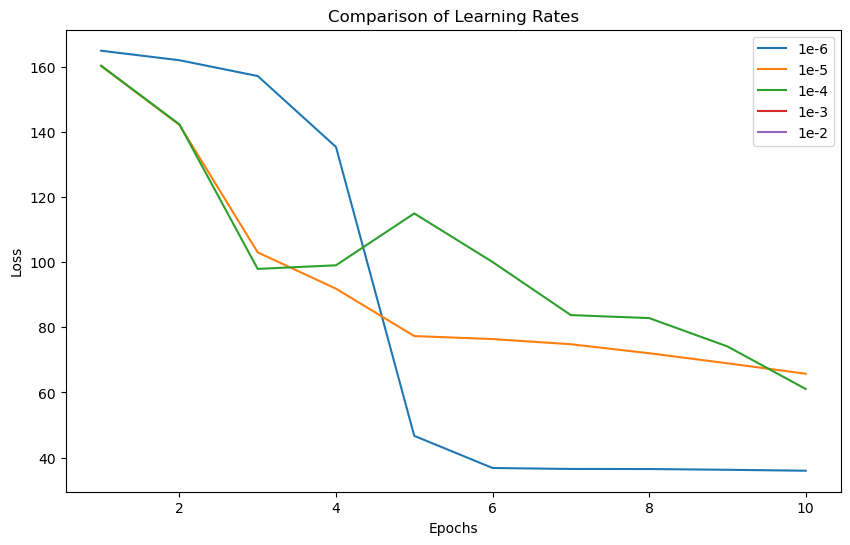

In [28]:
epochs = range(1, 11)
rates = [ '1e-6','1e-5','1e-4', '1e-3', '1e-2']
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(epochs, end_val_loss[i], label=rates[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Learning Rates')
plt.legend()
plt.show()

hmm maybe should have looked at it with smaller values also lets add to it, and also check if no sgd is better.

In [29]:
rates = [1e-7, 1e-8, 0]

for rate in rates:
        
    model=ANI(124)
    AdamW=torch.optim.AdamW(model.parameters())
    if rate !=0: 
        SGD= torch.optim.SGD(model.parameters(), lr=rate)
        SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='none')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 10
    early_stopping_learning_rate = 1.0E-5

    for epoch in range(max_epochs):
        rmse = validate(model)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        if rate !=0:
            SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        i=0
        for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = train_species[i]
            coordinates = train_X[i].to(device)
            true_energies = Y_train[i].to(device)
            #num_atoms = sum(1 for atom in species if atom != "H")
            num_atoms= len(species)
            num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            if rate !=0:
                SGD.zero_grad()
            loss.backward()
            AdamW.step()
            if rate !=0:
                SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(train_X))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)

training starting from epoch 1
RMSE: 163.10065560748558 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 159.82465711787583 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 147.9164645462774 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 93.84120821650116 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 48.9050537424999 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 43.00908342108492 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 42.43543070032526 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:17<00:00,  2.33it/s]


RMSE: 42.18677613210221 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]


RMSE: 41.754960970352286 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 41.25645815184967 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


training starting from epoch 1
RMSE: 161.98238663292142 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 158.5525074318099 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 146.39649883491032 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 89.48897619884696 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 57.877159535969305 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 48.105811873096215 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 46.14547156258312 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 45.31975208924106 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 44.80052503981454 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 44.32420019654434 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


training starting from epoch 1
RMSE: 163.22351293304686 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 160.30419627960356 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 148.57106655358194 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 97.5501678393966 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 63.542691714246466 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 54.4480604205916 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 53.039287452551726 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 51.82531071075664 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 50.94516266140729 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 50.211142900336796 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


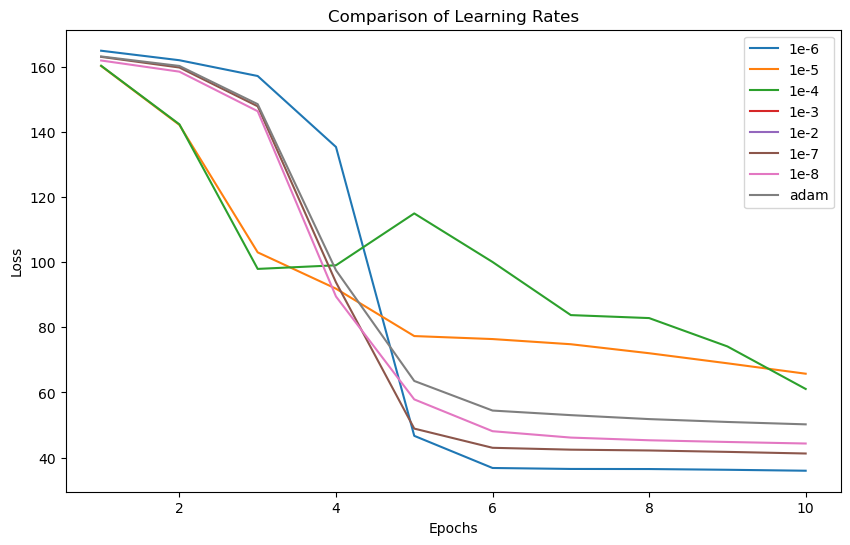

In [30]:
epochs = range(1, 11)
rates = [ '1e-6','1e-5','1e-4', '1e-3', '1e-2', '1e-7', '1e-8', 'adam']
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.plot(epochs, end_val_loss[i], label=rates[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Learning Rates')
plt.legend()
plt.show()

Actually I guess 1e-6, is a good choice.

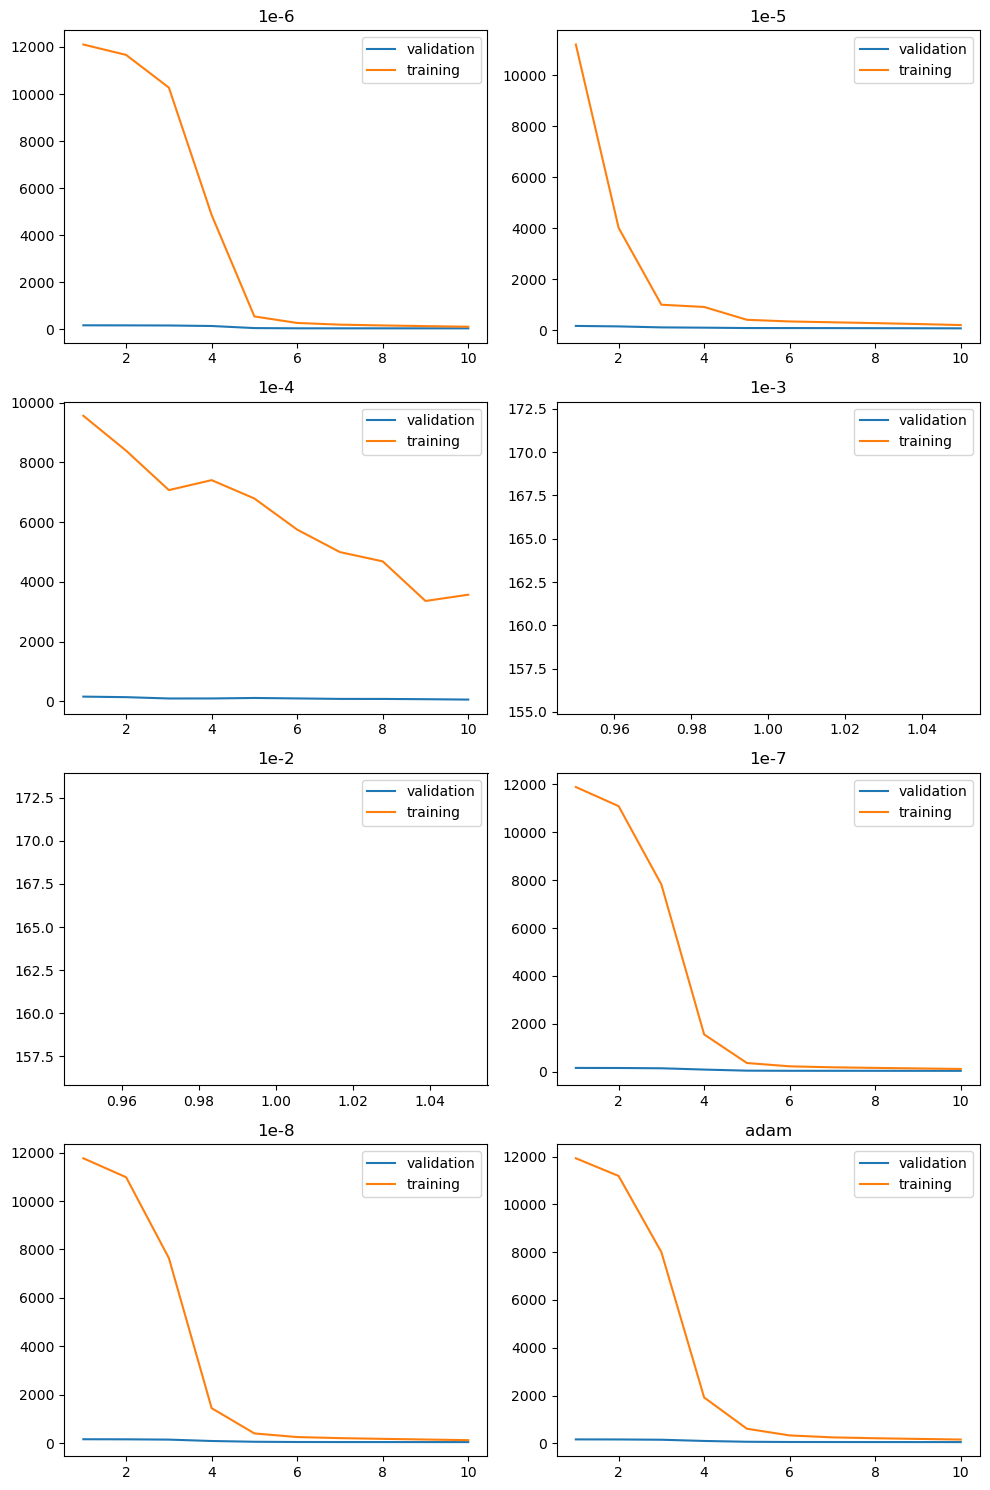

In [32]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15)) # 3 rows, 2 columns

k=0
for i in range(4):
    for j in range(2):
        axs[i, j].plot(epochs, end_val_loss[k], label="validation")
        axs[i, j].plot(epochs, end_train_loss[k], label="training")
        axs[i, j].legend()
        axs[i, j].set_title(rates[k])
        k+=1

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

1e-6 with adam appears to be the best however, interms of validation loss though the bias varriance trade off seems simular however due to the scaling on these graphs its a bit hard to tell, i should have changed where the training error begins from, i still dont understand how to error for validation is so low even from the start (how im calcuating loss) 

In [3]:
with open('tensor_data5.pkl', 'rb') as f:
    train_X5, train_Y5, train_species5, val_X5, val_Y5, val_species5 = pickle.load(f)

### Running a Model

This is slighlty diffrent then how torchani did their initalization as their method was constaly giving me na, results. This is the method from the paper

In [5]:
def init_params(m):
    if isinstance(m, nn.Linear):
        # Initialize weights
        std = 1 / 124
        nn.init.normal_(m.weight, mean=0, std=std)

        # Initialize biases to 0
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [6]:
model1=ANI(124)
model1.apply(init_params)
AdamW=torch.optim.AdamW(model1.parameters())
SGD= torch.optim.SGD(model1.parameters(), lr=1e-6)
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
model1=model1.to(device)

In [22]:
latest_checkpoint = 'latest7.pt'
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    model1.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

In [23]:
mse = torch.nn.MSELoss(reduction='none')
train_loss = []
validation_loss = []
val_X=tensor_val[1]
train_X=tensor_train[1]

def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model1.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = Y_val[i].to(device)
            predicted_energies = model1(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model1.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD


mse = torch.nn.MSELoss(reduction='none')
train_loss = []
validation_loss = []

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 200
early_stopping_learning_rate = 1.0E-8
best_model_checkpoint = 'best7.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)
    if AdamW_scheduler.last_epoch > 0: validation_loss.append(rmse)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(model1.state_dict(), best_model_checkpoint)
        
        
    AdamW_scheduler.step(rmse)
    SGD_scheduler.step(rmse)

#     # uncomment if running locally using tensorboard
#     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
    total_loss = 0
    i=0
    for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
        species = train_species[i]
        coordinates = train_X[i].to(device)
        true_energies = Y_train[i].to(device)
        #num_atoms = sum(1 for atom in species if atom != "H")
        num_atoms = len(species)
        num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
        predicted_energies = model1(coordinates, species)

        loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
        total_loss += loss.cpu().item()

        AdamW.zero_grad()
        SGD.zero_grad()
        loss.backward()
        AdamW.step()
        SGD.step()

#         # write current batch loss to TensorBoard
#         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
    train_loss.append(total_loss / len(train_X))

training starting from epoch 1
RMSE: 162.44514045611936 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 161.3920749796569 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 152.47889366223896 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 78.80628671934741 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 61.75028792013935 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]


RMSE: 60.66569089849894 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 59.169324960064614 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 57.584903808137724 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: 56.31083969405818 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 55.40721127783052 at epoch 10


epoch 10: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 54.74950616094852 at epoch 11


epoch 11: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 54.33321457691105 at epoch 12


epoch 12: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 53.819165351210984 at epoch 13


epoch 13: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 53.28591823753679 at epoch 14


epoch 14: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 52.75186594011567 at epoch 15


epoch 15: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]


RMSE: 52.31927114186417 at epoch 16


epoch 16: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 52.17725849802856 at epoch 17


epoch 17: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 52.07994431159287 at epoch 18


epoch 18: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 51.75826918025703 at epoch 19


epoch 19: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 52.301416446033336 at epoch 20


epoch 20: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 50.98517279867342 at epoch 21


epoch 21: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 51.75860507838722 at epoch 22


epoch 22: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 50.34619148760055 at epoch 23


epoch 23: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 52.05753943082388 at epoch 24


epoch 24: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 51.12740221411178 at epoch 25


epoch 25: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 51.66251871694741 at epoch 26


epoch 26: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]


RMSE: 50.247978715539 at epoch 27


epoch 27: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 50.62538082624196 at epoch 28


epoch 28: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]


RMSE: 49.58377604507324 at epoch 29


epoch 29: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 50.1650857155965 at epoch 30


epoch 30: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 50.04314408900348 at epoch 31


epoch 31: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 49.78847010734214 at epoch 32


epoch 32: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 50.774480623202734 at epoch 33


epoch 33: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 48.28100072237551 at epoch 34


epoch 34: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]


RMSE: 49.81667352049051 at epoch 35


epoch 35: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 46.858988290076375 at epoch 36


epoch 36: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 48.72426688501264 at epoch 37


epoch 37: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]


RMSE: 47.35756595985032 at epoch 38


epoch 38: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 49.19922632456253 at epoch 39


epoch 39: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]


RMSE: 48.84781341332601 at epoch 40


epoch 40: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 49.69879425643681 at epoch 41


epoch 41: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]


RMSE: 48.267928985714214 at epoch 42


epoch 42: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s]


RMSE: 47.72737260128592 at epoch 43


epoch 43: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 46.36644265858184 at epoch 44


epoch 44: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 46.1669493536803 at epoch 45


epoch 45: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 45.52958490052687 at epoch 46


epoch 46: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 47.393340825779184 at epoch 47


epoch 47: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]


RMSE: 48.87136348285571 at epoch 48


epoch 48: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 52.53429684343645 at epoch 49


epoch 49: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 49.90575947078837 at epoch 50


epoch 50: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 49.63363865238658 at epoch 51


epoch 51: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 45.63461942105686 at epoch 52


epoch 52: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 46.470092990407196 at epoch 53


epoch 53: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 45.42499411084436 at epoch 54


epoch 54: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 45.11367140831997 at epoch 55


epoch 55: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 50.421309171440726 at epoch 56


epoch 56: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 56.237505225994944 at epoch 57


epoch 57: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 52.36549899476986 at epoch 58


epoch 58: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 49.154038891063735 at epoch 59


epoch 59: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 45.6283198821098 at epoch 60


epoch 60: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 45.53363584715424 at epoch 61


epoch 61: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 44.42188109412052 at epoch 62


epoch 62: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 45.47156687994187 at epoch 63


epoch 63: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 48.74784715435945 at epoch 64


epoch 64: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 50.26262137032682 at epoch 65


epoch 65: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 48.73350762267463 at epoch 66


epoch 66: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 46.181222482720344 at epoch 67


epoch 67: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 44.93421814829415 at epoch 68


epoch 68: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 44.419089015355276 at epoch 69


epoch 69: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 44.30086611569843 at epoch 70


epoch 70: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 44.83609613993658 at epoch 71


epoch 71: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 46.41769898296542 at epoch 72


epoch 72: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]


RMSE: 47.39409078799399 at epoch 73


epoch 73: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 47.298873211090935 at epoch 74


epoch 74: 100%|██████████| 42/42 [00:15<00:00,  2.76it/s]


RMSE: 45.90507897125705 at epoch 75


epoch 75: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 44.835946587043004 at epoch 76


epoch 76: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 44.10415933728318 at epoch 77


epoch 77: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 43.8520427525668 at epoch 78


epoch 78: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 43.653440940966014 at epoch 79


epoch 79: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 44.7206670182031 at epoch 80


epoch 80: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]


RMSE: 46.25054951980134 at epoch 81


epoch 81: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 47.63594621532369 at epoch 82


epoch 82: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 46.745348600224474 at epoch 83


epoch 83: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 45.500131130235786 at epoch 84


epoch 84: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 44.00383210831575 at epoch 85


epoch 85: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]


RMSE: 44.07555885643493 at epoch 86


epoch 86: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 43.432488063762094 at epoch 87


epoch 87: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]


RMSE: 43.145018536787234 at epoch 88


epoch 88: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 43.78042160005333 at epoch 89


epoch 89: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 49.22300711558904 at epoch 90


epoch 90: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 48.48874451678257 at epoch 91


epoch 91: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 50.461125895941855 at epoch 92


epoch 92: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 43.7441857459162 at epoch 93


epoch 93: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 44.0503650039502 at epoch 94


epoch 94: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 44.63246742870253 at epoch 95


epoch 95: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 43.193088685413066 at epoch 96


epoch 96: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 42.42124198418104 at epoch 97


epoch 97: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 45.6873818356055 at epoch 98


epoch 98: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 48.256808010173394 at epoch 99


epoch 99: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 48.051458892991604 at epoch 100


epoch 100: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 44.82496863421717 at epoch 101


epoch 101: 100%|██████████| 42/42 [00:12<00:00,  3.24it/s]


RMSE: 43.20576973391877 at epoch 102


epoch 102: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 42.99372936758023 at epoch 103


epoch 103: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 42.705992431346125 at epoch 104


epoch 104: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 42.08362544834912 at epoch 105


epoch 105: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 43.000104095364584 at epoch 106


epoch 106: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]


RMSE: 44.964010684072456 at epoch 107


epoch 107: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 46.011748153040024 at epoch 108


epoch 108: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 44.92878017686813 at epoch 109


epoch 109: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 43.44547824830813 at epoch 110


epoch 110: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 42.56968408384753 at epoch 111


epoch 111: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]


RMSE: 42.50454999484303 at epoch 112


epoch 112: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 42.12773362439493 at epoch 113


epoch 113: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 41.85210987591622 at epoch 114


epoch 114: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 42.567818930050684 at epoch 115


epoch 115: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 44.61695029093331 at epoch 116


epoch 116: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 45.23469609275569 at epoch 117


epoch 117: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 44.831773989769225 at epoch 118


epoch 118: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 42.55620227409887 at epoch 119


epoch 119: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 42.43881556660164 at epoch 120


epoch 120: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 42.37564374053059 at epoch 121


epoch 121: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 42.27374997083926 at epoch 122


epoch 122: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 40.97922185267981 at epoch 123


epoch 123: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 42.152801461435196 at epoch 124


epoch 124: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 42.46371721530355 at epoch 125


epoch 125: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 47.14068639002094 at epoch 126


epoch 126: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 43.2092716170131 at epoch 127


epoch 127: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 43.48540426104736 at epoch 128


epoch 128: 100%|██████████| 42/42 [00:14<00:00,  2.82it/s]


RMSE: 41.84857534144336 at epoch 129


epoch 129: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 42.256804027521234 at epoch 130


epoch 130: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 42.00437270735138 at epoch 131


epoch 131: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 40.72717354683514 at epoch 132


epoch 132: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 41.24502386511731 at epoch 133


epoch 133: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 43.13009954413406 at epoch 134


epoch 134: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]


RMSE: 44.572689842371936 at epoch 135


epoch 135: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 43.39749765851256 at epoch 136


epoch 136: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 42.06970786086727 at epoch 137


epoch 137: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 41.44827705554292 at epoch 138


epoch 138: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]


RMSE: 41.76690291375593 at epoch 139


epoch 139: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 41.51371850685919 at epoch 140


epoch 140: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 40.54621711514239 at epoch 141


epoch 141: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: 40.66875888519666 at epoch 142


epoch 142: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]


RMSE: 42.45014702759051 at epoch 143


epoch 143: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 43.745051929233625 at epoch 144


epoch 144: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 43.401481144908885 at epoch 145


epoch 145: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 41.88648350478837 at epoch 146


epoch 146: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 41.2379576650229 at epoch 147


epoch 147: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 41.77980980884067 at epoch 148


epoch 148: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 41.863539905414555 at epoch 149


epoch 149: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 40.717157532230104 at epoch 150


epoch 150: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 40.016496621954786 at epoch 151


epoch 151: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 41.57433706980456 at epoch 152


epoch 152: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 43.84495451314247 at epoch 153


epoch 153: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 44.131673754116726 at epoch 154


epoch 154: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]


RMSE: 42.39207206309925 at epoch 155


epoch 155: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 41.047870914304326 at epoch 156


epoch 156: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 41.879979130272055 at epoch 157


epoch 157: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 42.73227042009944 at epoch 158


epoch 158: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]


RMSE: 41.41907786805415 at epoch 159


epoch 159: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 39.636110914055585 at epoch 160


epoch 160: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 40.747427706012154 at epoch 161


epoch 161: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 43.44604628437698 at epoch 162


epoch 162: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]


RMSE: 44.12711467250191 at epoch 163


epoch 163: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 42.03403413495103 at epoch 164


epoch 164: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 40.621061132136944 at epoch 165


epoch 165: 100%|██████████| 42/42 [00:17<00:00,  2.33it/s]


RMSE: 41.4190778815782 at epoch 166


epoch 166: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]


RMSE: 42.236554037776976 at epoch 167


epoch 167: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]


RMSE: 41.04141084388936 at epoch 168


epoch 168: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 39.344338905882246 at epoch 169


epoch 169: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 39.83718744002565 at epoch 170


epoch 170: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]


RMSE: 42.0931134116672 at epoch 171


epoch 171: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 41.87035434422369 at epoch 172


epoch 172: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 41.32968859323975 at epoch 173


epoch 173: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 39.835840033390625 at epoch 174


epoch 174: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 40.485770586961486 at epoch 175


epoch 175: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 41.204442226484936 at epoch 176


epoch 176: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 40.102228353220966 at epoch 177


epoch 177: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 38.91056045095297 at epoch 178


epoch 178: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]


RMSE: 39.53166646533958 at epoch 179


epoch 179: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 39.35347937884577 at epoch 180


epoch 180: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 41.40857146182437 at epoch 181


epoch 181: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 39.45722023509614 at epoch 182


epoch 182: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 39.725713664662884 at epoch 183


epoch 183: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]


RMSE: 39.729741883867206 at epoch 184


epoch 184: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]


RMSE: 39.93748408803259 at epoch 185


epoch 185: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 39.71549391282337 at epoch 186


epoch 186: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 38.880703470967816 at epoch 187


epoch 187: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]


RMSE: 38.65714093767795 at epoch 188


epoch 188: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 39.04278391780382 at epoch 189


epoch 189: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]


RMSE: 39.82799534979114 at epoch 190


epoch 190: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 39.60898999573805 at epoch 191


epoch 191: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 39.465927416420854 at epoch 192


epoch 192: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 39.26818251388857 at epoch 193


epoch 193: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 39.70999884849685 at epoch 194


epoch 194: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]


RMSE: 40.04782853441598 at epoch 195


epoch 195: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 39.51708715885606 at epoch 196


epoch 196: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 38.581902618123735 at epoch 197


epoch 197: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]


RMSE: 38.31765256099326 at epoch 198


epoch 198: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]


RMSE: 39.11347848199364 at epoch 199


epoch 199: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


Text(0, 0.5, 'Energy RMSE')

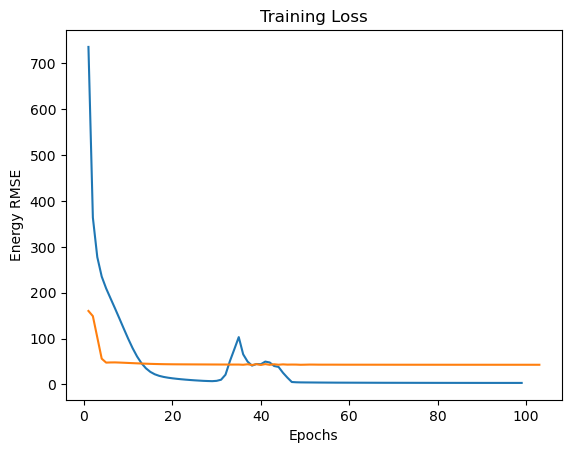

In [18]:
plt.plot(range(1,len(train_loss[4:])+1), train_loss[4:], label ="trainig")
plt.plot(range(1,len(validation_loss)+1), validation_loss, label="validation")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Energy RMSE")

The validation loss is stuck while the training loss is very underneath. This looks like over fitting at first glance, not 100% sure whats causing it (I have some ideas now but not at the time i was writing this part of the code up)

In [7]:
if os.path.isfile('best7.pt'):
    checkpoint = torch.load('best7.pt')
    model1.load_state_dict(checkpoint)

In [11]:
with open('val5_pca.pkl', 'rb') as f:
    val5, val_Y5, val_species5= pickle.load(f)

In [13]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model1.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species5[i]
            coordinates = val5[i].to(device)
            true_energies = val_Y5[i].unsqueeze(1).to(device)
            predicted_energies = model1(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model1.train(True)
    return math.sqrt(total_mse / count)

for i in range(3):
    rmse=validate()
    print(rmse)


67.2887612173048
67.2887612173048
67.2887612173048


### New model attempt
Stuck with 124 as other tests (included in a seperate notebook but realitively simular to these tests fir tdetermining the best value, also gave me 124). Look back at it though, I maybe should have experimented with either 214 ir 86 also.

In [14]:
class ANI(nn.Module):
    def __init__(self):
        super(ANI, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub(), "H": ANI_sub(),
                                    "O": ANI_sub(), "N": ANI_sub()})

    def forward(self, aevs, atom_types):
        # assuming aevs are being inserted in size (batch size, number of atoms, 384)
        atomic_energies=[]
        i = 0
        for atom in atom_types:
            aev=aevs[:,i,:].unsqueeze(1)
            energy = self.sub_nets[atom](aev)
            atomic_energies.append(energy)
            i=i+1
        energies = torch.cat(atomic_energies, dim =1)
        total_energies = torch.sum(energies, dim=1)
        return total_energies


class ANI_sub(nn.Module):
    def __init__(self):
        super(ANI_sub, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(124, 32),
            nn.CELU(alpha=0.1),
            nn.Linear(32,32),
            nn.CELU(alpha=0.1),
            nn.Linear(32,16),
            nn.CELU(alpha=0.1),
            nn.Linear(16,1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)

        return atomic_energy

In [15]:
model1=ANI()
AdamW=torch.optim.AdamW(model1.parameters())
SGD= torch.optim.SGD(model1.parameters(), lr=1e-6, momentum = 0.5)
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=100, threshold=0)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)
model1=model1.to(device)


In [16]:
latest_checkpoint = 'latest21.pt'
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    model1.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

In [17]:
train_loss = []
validation_loss = []

!!!!!! Try and Run Again !!!!!

In [18]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model1.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = val_Y[i].to(device)
            predicted_energies = model1(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model1.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD


mse = torch.nn.MSELoss(reduction='none')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 200
early_stopping_learning_rate = 1.0E-9
best_model_checkpoint = 'best21.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)
    if AdamW_scheduler.last_epoch > 0: validation_loss.append(rmse)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(model1.state_dict(), best_model_checkpoint)
        
        
    AdamW_scheduler.step(rmse)
    SGD_scheduler.step(rmse)

#     # uncomment if running locally using tensorboard
#     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
    total_loss = 0
    i=0
    for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
        species = train_species[i]
        coordinates = train_X[i].to(device)
        true_energies = train_Y[i].to(device)
        num_atoms = len(species)
        num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
        predicted_energies = model1(coordinates, species)

        loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
        total_loss += loss.cpu().item()

        AdamW.zero_grad()
        SGD.zero_grad()
        loss.backward()
        AdamW.step()
        SGD.step()

#         # write current batch loss to TensorBoard
#         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
    train_loss.append(total_loss / len(train_X))
    
    train_loss.append(total_loss / len(train_X))
    torch.save({
        'nn': model1.state_dict(),
        'AdamW': AdamW.state_dict(),
        'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 39
RMSE: 48.022622678831176 at epoch 39


epoch 39: 100%|██████████| 42/42 [01:15<00:00,  1.80s/it]


RMSE: 47.84254657880746 at epoch 40


epoch 40: 100%|██████████| 42/42 [01:06<00:00,  1.57s/it]


RMSE: 46.502237427879344 at epoch 41


epoch 41: 100%|██████████| 42/42 [01:09<00:00,  1.66s/it]


RMSE: 49.70952916910937 at epoch 42


epoch 42: 100%|██████████| 42/42 [01:16<00:00,  1.81s/it]


RMSE: 52.8746436171127 at epoch 43


epoch 43:   2%|▏         | 1/42 [00:03<02:21,  3.46s/it]


KeyboardInterrupt: 

In [19]:
for loss in train_loss:
    print(loss)   ## even training error is bad, the model is struggling to learn the information

56.44004129228138
56.44004129228138
45.18900989918482
45.18900989918482
44.55792488938286
44.55792488938286
35.81533769198826
35.81533769198826


### New model based on working regular model
My first part of the project, i was able to get good validation results and realtively generalizable results to the 5 large atom file also using ReLU instead so I though might be applicable heare 

In [99]:
class ANI2(nn.Module):
    def __init__(self, snd):
        super(ANI2, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub2(snd), "H": ANI_sub2(snd),
                                    "O": ANI_sub2(snd), "N": ANI_sub2(snd)})

    def forward(self, aevs, atom_types):
        # assuming aevs are being inserted in size (batch size, number of atoms, 384)
        atomic_energies=[]
        i = 0
        for atom in atom_types:
            aev=aevs[:,i,:].unsqueeze(1)
            energy = self.sub_nets[atom](aev)
            atomic_energies.append(energy)
            i=i+1
        energies = torch.cat(atomic_energies, dim =1)
        total_energies = torch.sum(energies, dim=1)
        return total_energies


class ANI_sub2(nn.Module):
    def __init__(self, snd):
        super(ANI_sub2, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(124, snd),
            nn.ReLU(),
            nn.Linear(snd,snd),
            nn.ReLU(),
             nn.Linear(snd,math.ceil(snd/2)),
             nn.ReLU(),
            nn.Linear(math.ceil(snd/2),1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)

        return atomic_energy

In [87]:
model3=ANI2()
#model3.apply(init_params)
AdamW=torch.optim.AdamW(model3.parameters())
SGD= torch.optim.SGD(model3.parameters(), lr=1e-3)
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=100, threshold=0)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)
model3=model3.to(device)

latest_checkpoint = 'latest23.pt'
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    model3.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

In [88]:
train_loss=[]
validation_loss=[]

In [89]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model3.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = val_Y[i].to(device)
            predicted_energies = model3(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model3.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD


mse = torch.nn.MSELoss(reduction='mean')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 200
early_stopping_learning_rate = 1.0E-7
best_model_checkpoint = 'best23.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)
    if AdamW_scheduler.last_epoch > 0: validation_loss.append(rmse)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(model3.state_dict(), best_model_checkpoint)
        
        
    AdamW_scheduler.step(rmse)
    SGD_scheduler.step(rmse)

#     # uncomment if running locally using tensorboard
#     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
    total_loss = 0
    i=0
    for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
        species = train_species[i]
        coordinates = train_X[i].to(device)
        true_energies = train_Y[i].to(device)
        num_atoms = len(species)
        num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
        predicted_energies = model3(coordinates, species)

        #loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
        loss = mse(predicted_energies, true_energies)
        total_loss += loss.cpu().item()

        AdamW.zero_grad()
        SGD.zero_grad()
        loss.backward()
        AdamW.step()
        SGD.step()

#         # write current batch loss to TensorBoard
#         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
    train_loss.append(total_loss / len(train_X))
    
    torch.save({
        'nn': model3.state_dict(),
        'AdamW': AdamW.state_dict(),
        'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 1
RMSE: 162.35322077639165 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: nan at epoch 2


epoch 2:  29%|██▊       | 12/42 [00:05<00:12,  2.32it/s]


KeyboardInterrupt: 

I dont remeber what exactly gave me this graph, sorry (bad coding practice ik) I think it was from the first aNI model attemot though which is why I decided to switch over to using ReLU. I thought the oscilalztion was due to my parameters, but after completeting the assignemnt I think the osicallilation is due to the data being a poor represenative of the distribution. I took the pca, by combining all the features into on ehuge flattened matrix. While i think this was a good methid for discovering which number of features would ahve been best. If i had time to do it again I would instead take the individual pca by molecule aftwards, as i think the 124 features that were pulled were too generalized to molecules and it might have been better to do another way but also maybe not becuase then the 124 features the model is learning are not always the same 124 features. When i realized this i thought maybe the pca needed to be on the val and train together but i attemoted a small scale version of that and got simular oscialtion behavior.

Text(0, 0.5, 'Energy RMSE')

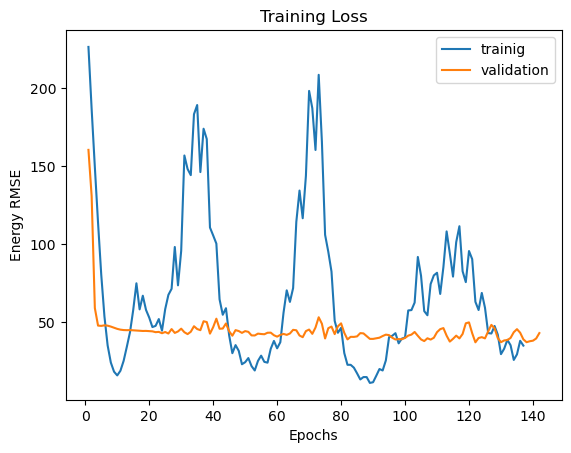

In [56]:
plt.plot(range(1,len(train_loss[5:])+1), train_loss[5:], label ="trainig")
plt.plot(range(1,len(validation_loss)+1), validation_loss, label="validation")
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Energy RMSE")

In [100]:
def validate(model):
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = val_Y[i].to(device)
            predicted_energies = model(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD
second = [ 22, 32, 40, 48, 56, 64]

end_train_loss=[]
end_val_loss=[]

for snd in second:
    model=ANI2(snd)
    AdamW=torch.optim.AdamW(model.parameters())
    #SGD= torch.optim.SGD(model.parameters(), lr=1e-3)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    #SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='mean')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 9
    early_stopping_learning_rate = 1.0E-9

    for epoch in range(max_epochs):
        rmse = validate(model)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        i=0
        for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = train_species[i]
            coordinates = train_X[i].to(device)
            true_energies = train_Y[i].to(device)
#             num_atoms = len(species)
#             num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = mse(predicted_energies, true_energies)
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            #SGD.zero_grad()
            loss.backward()
            AdamW.step()
            #SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(train_X))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)


training starting from epoch 1
RMSE: 163.5077051687241 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]


RMSE: 159.83606601586015 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]


RMSE: 144.13065595350758 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 80.04751235355022 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]


RMSE: 51.90370853242843 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]


RMSE: 44.15663818270021 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]


RMSE: 43.05916930291811 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]


RMSE: 42.42867266395405 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]


RMSE: 41.86240612542341 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


training starting from epoch 1
RMSE: 160.70801296463992 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]


RMSE: 150.41707590509327 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]


RMSE: 88.0648915614528 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]


RMSE: 45.81936686322608 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 36.61982826445688 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 34.8351343124251 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 34.2769205367481 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]


RMSE: 34.158381336513216 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]


RMSE: 33.88567339730711 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]


training starting from epoch 1
RMSE: 163.24559576648068 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]


RMSE: 153.34989035606083 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:13<00:00,  3.16it/s]


RMSE: 83.57710525437345 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]


RMSE: 37.92497704099219 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]


RMSE: 33.38603200058673 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]


RMSE: 30.19939075804568 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]


RMSE: 29.252430420521545 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


RMSE: 29.050513755683678 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]


RMSE: 29.36888214278507 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]


training starting from epoch 1
RMSE: 163.3514020681131 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]


RMSE: 146.64623389360986 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]


RMSE: 42.468796183339194 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]


RMSE: 36.07841419169894 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]


RMSE: 33.96360254866334 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]


RMSE: 31.902263612661027 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]


RMSE: 32.77406420560051 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]


RMSE: 32.54916754819621 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]


RMSE: 31.47908902080626 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]


training starting from epoch 1
RMSE: 162.87608111674274 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]


RMSE: 145.7842856888036 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]


RMSE: 50.86595368779978 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]


RMSE: 33.33347175442898 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:20<00:00,  2.00it/s]


RMSE: 29.775477613265238 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]


RMSE: 29.118427181030675 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]


RMSE: 31.682890782586114 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:13<00:00,  3.22it/s]


RMSE: 31.36977152128919 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]


RMSE: 29.340297772072 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]


training starting from epoch 1
RMSE: 162.19530018343568 at epoch 1


epoch 1: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


RMSE: 135.20040128594027 at epoch 2


epoch 2: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


RMSE: 55.67975931606445 at epoch 3


epoch 3: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]


RMSE: 26.287573576973756 at epoch 4


epoch 4: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]


RMSE: 27.371582859526644 at epoch 5


epoch 5: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]


RMSE: 26.587339422783323 at epoch 6


epoch 6: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]


RMSE: 26.139631296298617 at epoch 7


epoch 7: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]


RMSE: 30.63622448270008 at epoch 8


epoch 8: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]


RMSE: 31.159684448211138 at epoch 9


epoch 9: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]


was looking to see if anything can stop osicilating, thought that i would try and find a better model

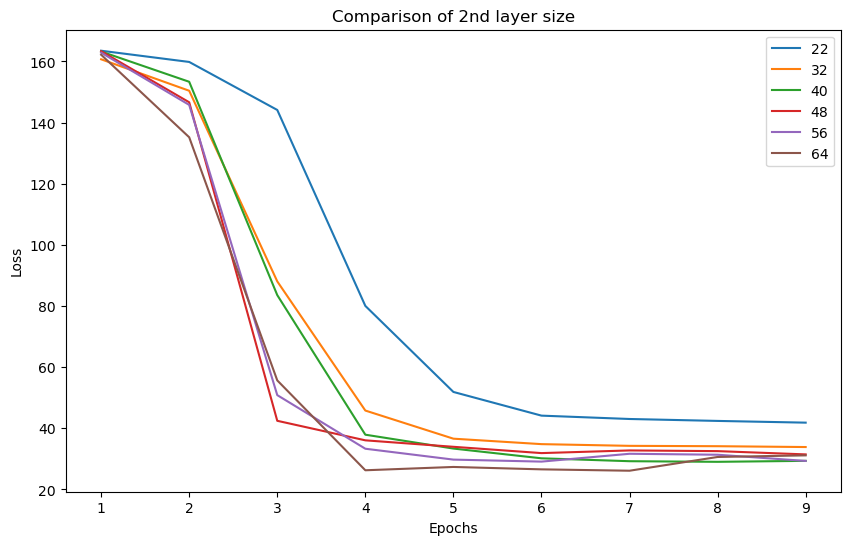

In [108]:
epochs = range(1, 10)
second = [ '22', '32', '40', '48', '56', '64']
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(epochs, end_val_loss[i], label=second[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of 2nd layer size')
plt.legend()
plt.show()

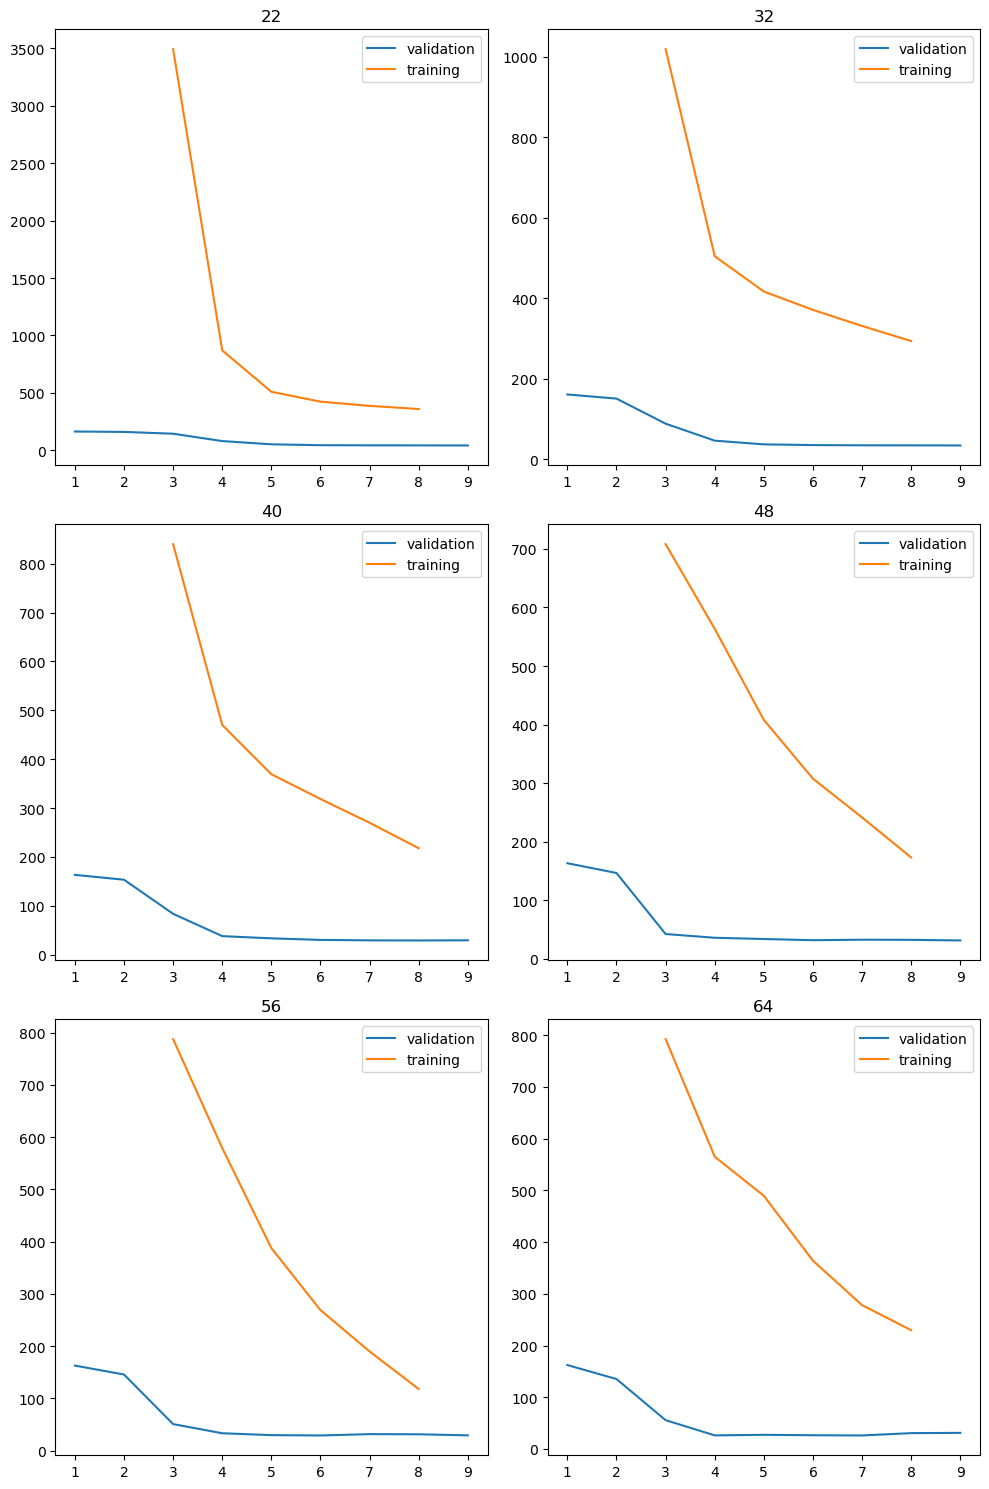

In [106]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns

k=0
for i in range(3):
    for j in range(2):
        axs[i, j].plot(epochs, end_val_loss[k], label="validation")
        axs[i, j].plot(range(3, len(epochs)), end_train_loss[k][3:], label="training")
        axs[i, j].legend()
        axs[i, j].set_title(second[k])
        k+=1

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

choosing 56 as it doesnt reach the validation data as quickly and it looks like it will converage quickly based on its slope. but will also test with 22 if it doesnt work.

In [4]:
class ANI3(nn.Module):
    def __init__(self ):
        super(ANI3, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub3(), "H": ANI_sub3(),
                                    "O": ANI_sub3(), "N": ANI_sub3()})

    def forward(self, aevs, atom_types):
        # assuming aevs are being inserted in size (batch size, number of atoms, 384)
        atomic_energies=[]
        i = 0
        for atom in atom_types:
            aev=aevs[:,i,:].unsqueeze(1)
            energy = self.sub_nets[atom](aev)
            atomic_energies.append(energy)
            i=i+1
        energies = torch.cat(atomic_energies, dim =1)
        total_energies = torch.sum(energies, dim=1)
        return total_energies


class ANI_sub3(nn.Module):
    def __init__(self):
        super(ANI_sub3, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(124, 56),
            nn.ReLU(),
            nn.Linear(56,56),
            nn.ReLU(),
             nn.Linear(56,28),
             nn.ReLU(),
            nn.Linear(28,1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)

        return atomic_energy

In [120]:
def validate(model):
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model.train(False)
    with torch.no_grad():
        for i in range(len(exp_valX)):
            species = exp_val_species[i]
            coordinates = exp_valX[i].to(device)
            true_energies = exp_valY[i].to(device)
            predicted_energies = model(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD
rates = [ 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

end_train_loss=[]
end_val_loss=[]

for rate in rates:
    model=ANI3()
    AdamW=torch.optim.AdamW(model.parameters())
    SGD= torch.optim.SGD(model.parameters(), lr=rate)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='mean')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 10
    early_stopping_learning_rate = 1.0E-9

    for epoch in range(max_epochs):
        rmse = validate(model)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        i=0
        for i in tqdm(range(len(exp_trainX)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = exp_train_species[i]
            coordinates = exp_trainX[i].to(device)
            true_energies = exp_trainY[i].to(device)
#             num_atoms = len(species)
#             num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = mse(predicted_energies, true_energies)
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            SGD.zero_grad()
            loss.backward()
            AdamW.step()
            SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(exp_trainX))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)


training starting from epoch 1
RMSE: 190.97334508132099 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


RMSE: 188.37228747800356 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:05<00:00,  2.43it/s]


RMSE: 183.54276713476298 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


RMSE: 170.99104648032883 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


RMSE: 139.76340494785126 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


RMSE: 85.29701303388947 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


RMSE: 83.05789637146255 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


RMSE: 89.93912012774543 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


RMSE: 85.50588352308752 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


RMSE: 84.37811712107244 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


training starting from epoch 1
RMSE: 190.1762068669405 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


RMSE: 185.00504553333118 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


RMSE: 170.9461678233148 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


RMSE: 122.50378887101905 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


RMSE: 78.49861160955764 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]


RMSE: 88.63640088840489 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


RMSE: 86.98937497452808 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


RMSE: 85.47487279847464 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


RMSE: 83.75464795503486 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]


RMSE: 82.38217598821781 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


training starting from epoch 1
RMSE: 190.61083060304063 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


RMSE: 181.6655896269347 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.08it/s]


RMSE: 84.59535662510211 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


RMSE: 75.20810314061097 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


RMSE: 91.71292371983975 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


RMSE: 155.97345723350884 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


RMSE: 119.38687141098049 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


RMSE: 48.08111898992004 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s]


RMSE: 84.53960470862705 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


RMSE: 58.544228443805885 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:06<00:00,  2.26it/s]


training starting from epoch 1
RMSE: 192.2333644763499 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]


RMSE: 188.5753274701169 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


RMSE: nan at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


RMSE: nan at epoch 4


epoch 4: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


RMSE: nan at epoch 5


epoch 5: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


RMSE: nan at epoch 6


epoch 6: 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


RMSE: nan at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


RMSE: nan at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


RMSE: nan at epoch 9


epoch 9: 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]


RMSE: nan at epoch 10


epoch 10: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


training starting from epoch 1
RMSE: 191.6341720299838 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


RMSE: nan at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


RMSE: nan at epoch 3


epoch 3: 100%|██████████| 14/14 [00:05<00:00,  2.36it/s]


RMSE: nan at epoch 4


epoch 4: 100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


RMSE: nan at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


RMSE: nan at epoch 6


epoch 6: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


RMSE: nan at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


RMSE: nan at epoch 8


epoch 8: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


RMSE: nan at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


RMSE: nan at epoch 10


epoch 10: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


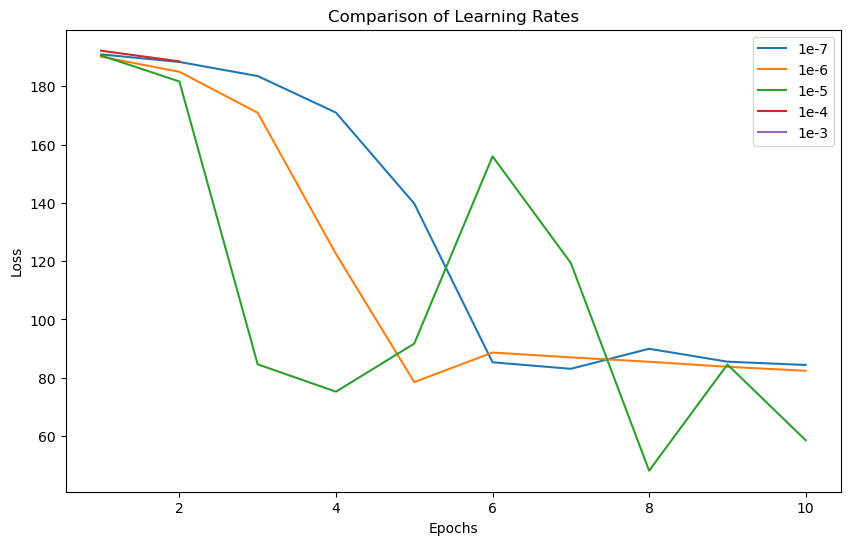

In [121]:
epochs = range(1, 11)
rates = [ '1e-7', '1e-6', '1e-5', '1e-4', '1e-3']
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(epochs, end_val_loss[i], label=rates[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Learning Rates')
plt.legend()
plt.show()

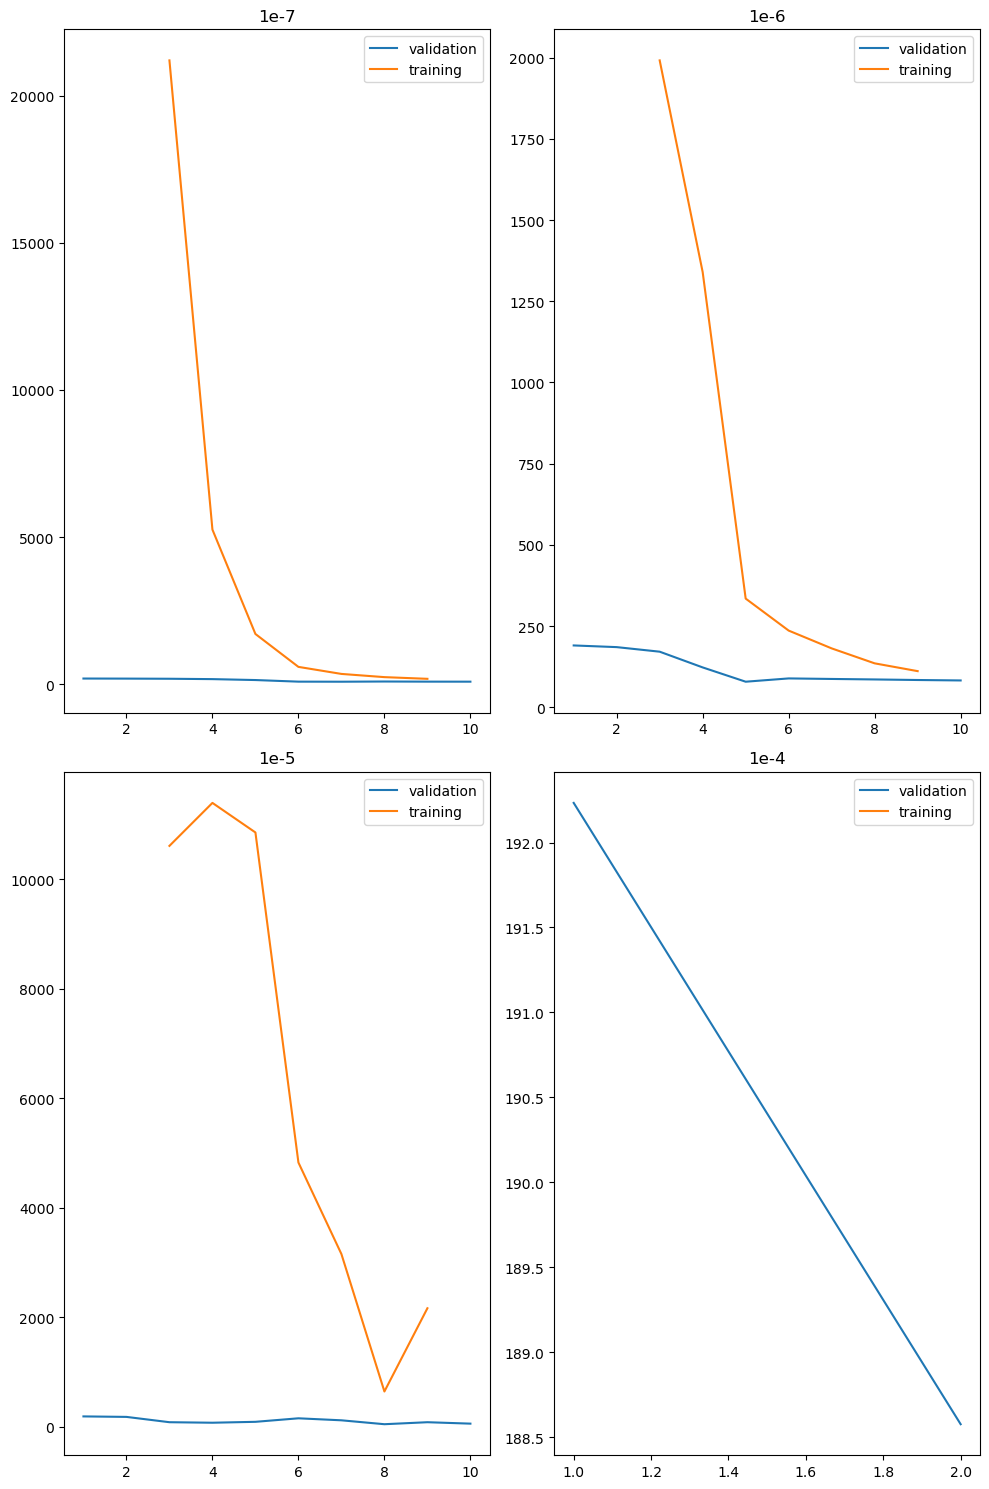

In [123]:
fig, axs = plt.subplots(2, 2, figsize=(10, 15)) # 3 rows, 2 columns

k=0
for i in range(2):
    for j in range(2):
        axs[i, j].plot(epochs, end_val_loss[k], label="validation")
        axs[i, j].plot(range(3, len(epochs)), end_train_loss[k][3:], label="training")
        axs[i, j].legend()
        axs[i, j].set_title(rates[k])
        k+=1

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

Originally wanted to say 1e-5, a sit giving lowest validation, but im not sure based on the way its training curve look. 1e-7 on the other hand already is reaching a good relationship with the validation error so lets start there.

In [127]:
def validate(model):
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model.train(False)
    with torch.no_grad():
        for i in range(len(exp_valX)):
            species = exp_val_species[i]
            coordinates = exp_valX[i].to(device)
            true_energies = exp_valY[i].to(device)
            predicted_energies = model(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD
momnetum = [ 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]

end_train_loss=[]
end_val_loss=[]

for m in momnetum:
    model=ANI3()
    AdamW=torch.optim.AdamW(model.parameters())
    SGD= torch.optim.SGD(model.parameters(), lr=1e-7, momentum =m)
    AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=10, threshold=0.001)
    SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=10, threshold=0.001)
    model=model.to(device)
    
    mse = torch.nn.MSELoss(reduction='mean')
    train_loss = []
    validation_loss = []

    print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
    max_epochs = 10
    early_stopping_learning_rate = 1.0E-9

    for epoch in range(max_epochs):
        rmse = validate(model)
        print('RMSE:', rmse, 'at epoch', epoch + 1)
#         if AdamW_scheduler.last_epoch > 0: 
        validation_loss.append(rmse)

        learning_rate = AdamW.param_groups[0]['lr']

        if learning_rate < early_stopping_learning_rate:
            break

        # checkpoint
#         if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
#             torch.save(model3.state_dict(), best_model_checkpoint)

        AdamW_scheduler.step(rmse)
        SGD_scheduler.step(rmse)

    #     # uncomment if running locally using tensorboard
    #     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
    #     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
        total_loss = 0
        i=0
        for i in tqdm(range(len(exp_trainX)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
            species = exp_train_species[i]
            coordinates = exp_trainX[i].to(device)
            true_energies = exp_trainY[i].to(device)
#             num_atoms = len(species)
#             num_atoms_tensor = torch.tensor(num_atoms, dtype=true_energies.dtype, device=true_energies.device)
            predicted_energies = model(coordinates, species)

            loss = mse(predicted_energies, true_energies)
            total_loss += loss.cpu().item()

            AdamW.zero_grad()
            SGD.zero_grad()
            loss.backward()
            AdamW.step()
            SGD.step()

    #         # write current batch loss to TensorBoard
    #         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
        train_loss.append(total_loss / len(exp_trainX))
    end_train_loss.append(train_loss)
    end_val_loss.append(validation_loss)


training starting from epoch 1
RMSE: 191.88964112493787 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


RMSE: 189.29684840886176 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


RMSE: 184.38930604146935 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


RMSE: 169.01035402897588 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


RMSE: 112.78264181210068 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]


RMSE: 65.98217333669555 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


RMSE: 91.40743785620009 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.24it/s]


RMSE: 75.61019180803113 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.16it/s]


RMSE: 76.59399567013786 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.01it/s]


RMSE: 76.61587056086562 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]


training starting from epoch 1
RMSE: 190.72090817969564 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


RMSE: 186.86655602501006 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:05<00:00,  2.45it/s]


RMSE: 179.33318334330792 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]


RMSE: 158.52653482027475 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


RMSE: 100.00441200708308 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


RMSE: 66.27059740874736 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


RMSE: 88.22376463098486 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]


RMSE: 73.92943354296867 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:04<00:00,  2.95it/s]


RMSE: 75.42865373509922 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


RMSE: 74.44682553871166 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


training starting from epoch 1
RMSE: 191.3183631386758 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


RMSE: 188.87096046550616 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


RMSE: 184.65676722994473 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


RMSE: 173.56312543447007 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


RMSE: 142.06851092383437 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


RMSE: 85.65744942752738 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]


RMSE: 97.98786974263467 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


RMSE: 94.80083981070322 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


RMSE: 90.36565820571542 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


RMSE: 90.32445863305233 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]


training starting from epoch 1
RMSE: 191.07459148548682 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]


RMSE: 188.0367969615729 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


RMSE: 182.68351194009145 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


RMSE: 168.4658571348156 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]


RMSE: 130.75112201875592 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


RMSE: 78.77577242582763 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:06<00:00,  2.33it/s]


RMSE: 90.32168734822375 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


RMSE: 90.33674147320176 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


RMSE: 87.2553502317942 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


RMSE: 86.42312716843966 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


training starting from epoch 1
RMSE: 192.68599076987397 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


RMSE: 190.11655450902012 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


RMSE: 186.179460599029 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]


RMSE: 176.4060323290795 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:04<00:00,  3.22it/s]


RMSE: 151.39286144571537 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]


RMSE: 99.71842004283972 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]


RMSE: 80.3049027489108 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


RMSE: 91.23514868357421 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


RMSE: 87.73026158072182 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


RMSE: 85.9471969310534 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


training starting from epoch 1
RMSE: 190.38889238751753 at epoch 1


epoch 1: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


RMSE: 186.7946208970605 at epoch 2


epoch 2: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


RMSE: 180.04314340221032 at epoch 3


epoch 3: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


RMSE: 162.32350038353945 at epoch 4


epoch 4: 100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


RMSE: 119.52572968554342 at epoch 5


epoch 5: 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]


RMSE: 87.3854964371178 at epoch 6


epoch 6: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


RMSE: 98.24696133803691 at epoch 7


epoch 7: 100%|██████████| 14/14 [00:06<00:00,  2.23it/s]


RMSE: 94.6616607680664 at epoch 8


epoch 8: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


RMSE: 91.62100927895281 at epoch 9


epoch 9: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


RMSE: 90.68413027793413 at epoch 10


epoch 10: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]


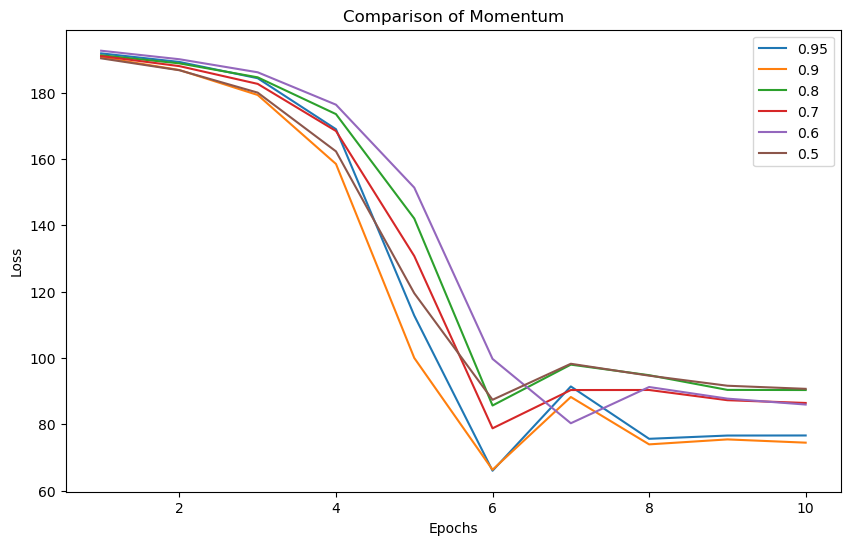

In [129]:
epochs = range(1, 11)
momentums = [ '0.95', '0.9', '0.8', '0.7', '0.6', '0.5']
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(epochs, end_val_loss[i], label=momentums[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Momentum')
plt.legend()
plt.show()

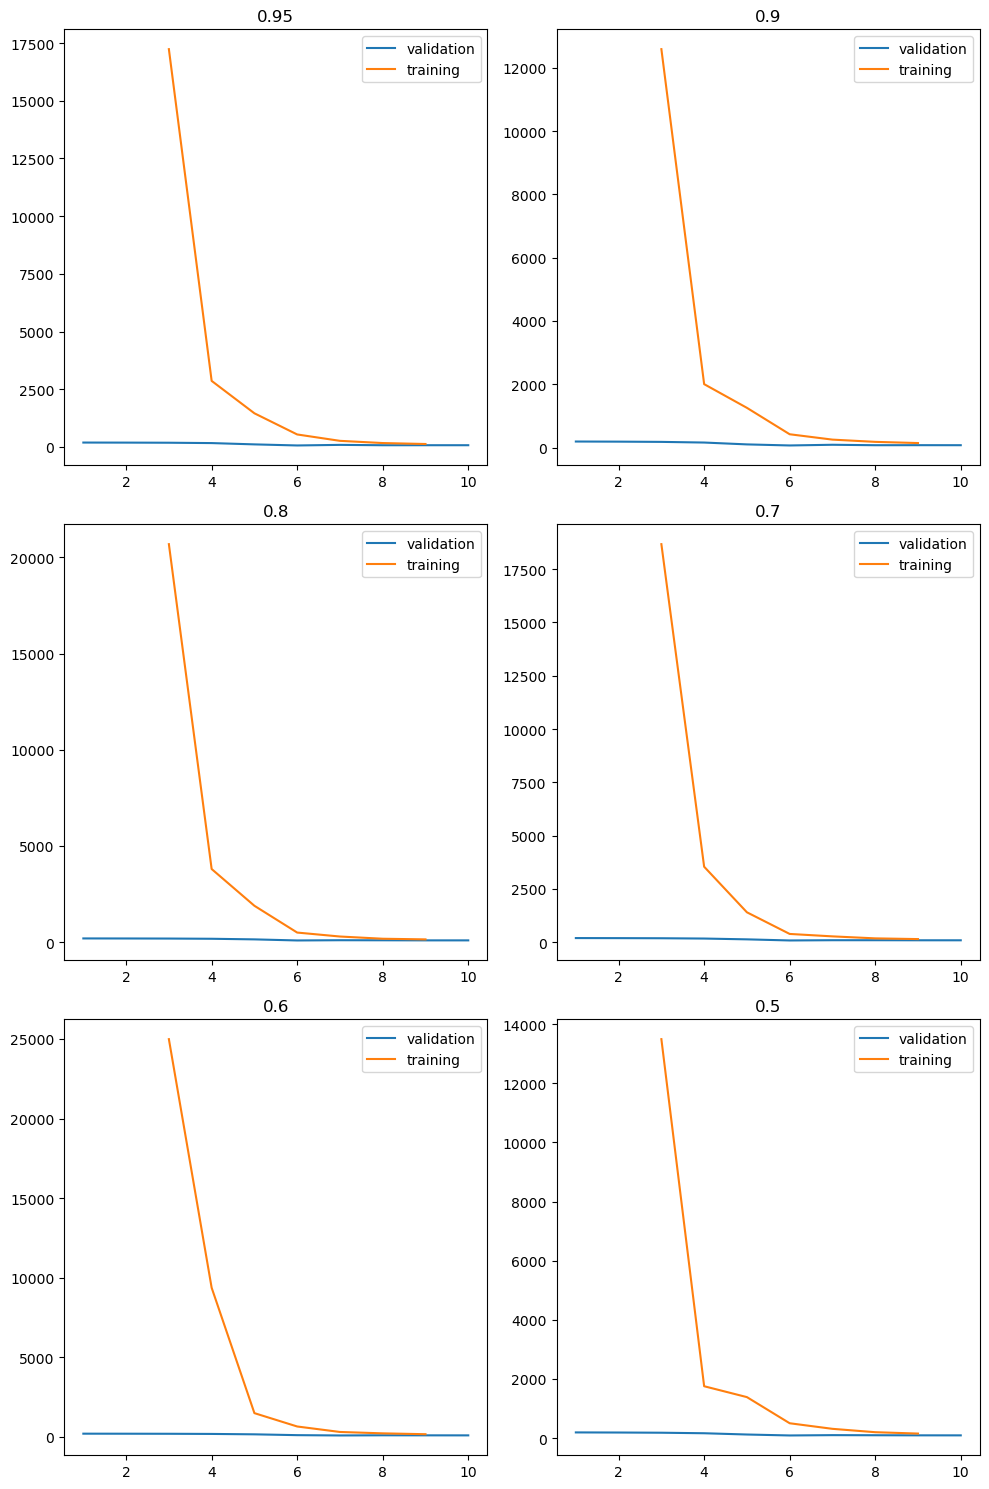

In [130]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15)) # 3 rows, 2 columns

k=0
for i in range(3):
    for j in range(2):
        axs[i, j].plot(epochs, end_val_loss[k], label="validation")
        axs[i, j].plot(range(3, len(epochs)), end_train_loss[k][3:], label="training")
        axs[i, j].legend()
        axs[i, j].set_title(momentums[k])
        k+=1

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

Lets use 0.6 as 0.9 is the base, and i already know the rmse is trying to oscilate using it

On a second thouhgt, Im not sure using SGD in combination with ADAM is as effective here as it was in the first mdoel.

In [5]:
model5=ANI3()
AdamW=torch.optim.AdamW(model5.parameters())
#SGD= torch.optim.SGD(model5.parameters(), lr=1e-7, momentum =0.6)
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=100, threshold=0)
#SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)
model5=model5.to(device)

latest_checkpoint = 'latest25.pt'
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    model5.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    #SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    #SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

In [7]:
train_loss=[]
validation_loss=[]

In [8]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model5.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = val_Y[i].to(device)
            predicted_energies = model5(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model5.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD


mse = torch.nn.MSELoss(reduction='mean')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 200
early_stopping_learning_rate = 1.0E-9
best_model_checkpoint = 'best25.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)
    if AdamW_scheduler.last_epoch > 0: validation_loss.append(rmse)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(model5.state_dict(), best_model_checkpoint)
        
        
    AdamW_scheduler.step(rmse)
    #SGD_scheduler.step(rmse)

#     # uncomment if running locally using tensorboard
#     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
    total_loss = 0
    i=0
    for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
        species = train_species[i]
        coordinates = train_X[i].to(device)
        true_energies = train_Y[i].to(device)
        predicted_energies = model5(coordinates, species)

        #loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
        loss = mse(predicted_energies, true_energies)
        total_loss += loss.cpu().item()

        AdamW.zero_grad()
        #SGD.zero_grad()
        loss.backward()
        AdamW.step()
        #SGD.step()

#         # write current batch loss to TensorBoard
#         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
    train_loss.append(total_loss / len(train_X))
    
    torch.save({
        'nn': model5.state_dict(),
        'AdamW': AdamW.state_dict(),
        #'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        #'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 40
RMSE: 31.45038868398447 at epoch 40


epoch 40: 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]


RMSE: 32.17681545669657 at epoch 41


epoch 41: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]


RMSE: 32.11614273382271 at epoch 42


epoch 42: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]


RMSE: 31.200802166548453 at epoch 43


epoch 43: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]


RMSE: 30.43001539205009 at epoch 44


epoch 44: 100%|██████████| 42/42 [00:22<00:00,  1.91it/s]


RMSE: 30.09477725559204 at epoch 45


epoch 45: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]


RMSE: 29.77095203854926 at epoch 46


epoch 46: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]


RMSE: 29.61422892698456 at epoch 47


epoch 47: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]


RMSE: 30.993338053072726 at epoch 48


epoch 48: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]


RMSE: 34.29333902126021 at epoch 49


epoch 49: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]


RMSE: 36.7943827346308 at epoch 50


epoch 50: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]


RMSE: 35.74140845003604 at epoch 51


epoch 51: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]


RMSE: 32.15795872610759 at epoch 52


epoch 52: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]


RMSE: 33.008957342504246 at epoch 53


epoch 53: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 39.562664913328646 at epoch 54


epoch 54: 100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


RMSE: 40.9420575126353 at epoch 55


epoch 55: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]


RMSE: 30.82860118095046 at epoch 56


epoch 56: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


RMSE: 46.67399181575722 at epoch 57


epoch 57: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]


RMSE: 76.85291057515722 at epoch 58


epoch 58: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


RMSE: 45.2606627529716 at epoch 59


epoch 59: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]


RMSE: 47.93018771597769 at epoch 60


epoch 60: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]


RMSE: 58.517489589022276 at epoch 61


epoch 61: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]


RMSE: 33.35953808849011 at epoch 62


epoch 62: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]


RMSE: 36.1311769060443 at epoch 63


epoch 63: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]


RMSE: 35.346541866889496 at epoch 64


epoch 64:  60%|█████▉    | 25/42 [00:15<00:10,  1.63it/s]


KeyboardInterrupt: 

Checking to see if the behavior is due to the wait im using training and validation from different PCA, but seems to act the same regardless

In [135]:
train_indicies, val_indicies = train_test_split(range(len(train_X)), test_size=1/5, random_state=42)


In [136]:
val_X= subset_data(train_X,val_indicies)
val_Y= subset_data(train_Y,val_indicies)
val_species= subset_data(train_species,val_indicies)

train_X= subset_data(train_X,train_indicies)
train_Y= subset_data(train_Y,train_indicies)
train_species= subset_data(train_species,train_indicies)

In [138]:
train_loss=[]
validation_loss=[]

In [ ]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model5.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = val_Y[i].to(device)
            predicted_energies = model5(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model5.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD


mse = torch.nn.MSELoss(reduction='mean')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 200
early_stopping_learning_rate = 1.0E-9
best_model_checkpoint = 'best25.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)
    if AdamW_scheduler.last_epoch > 0: validation_loss.append(rmse)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(model5.state_dict(), best_model_checkpoint)
        
        
    AdamW_scheduler.step(rmse)
    #SGD_scheduler.step(rmse)

#     # uncomment if running locally using tensorboard
#     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
    total_loss = 0
    i=0
    for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
        species = train_species[i]
        coordinates = train_X[i].to(device)
        true_energies = train_Y[i].to(device)
        predicted_energies = model5(coordinates, species)

        #loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
        loss = mse(predicted_energies, true_energies)
        total_loss += loss.cpu().item()

        AdamW.zero_grad()
        #SGD.zero_grad()
        loss.backward()
        AdamW.step()
        #SGD.step()

#         # write current batch loss to TensorBoard
#         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
    train_loss.append(total_loss / len(train_X))
    
    torch.save({
        'nn': model5.state_dict(),
        'AdamW': AdamW.state_dict(),
        'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 31
RMSE: 31.576300323919025 at epoch 31


epoch 31: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]


RMSE: 31.120681698373854 at epoch 32


epoch 32: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]


RMSE: 32.212111230723686 at epoch 33


epoch 33: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]


RMSE: 33.20004101573983 at epoch 34


epoch 34: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]


RMSE: 31.93958898454089 at epoch 35


epoch 35: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]


RMSE: 31.077019735717208 at epoch 36


epoch 36: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]


RMSE: 30.445917792950453 at epoch 37


epoch 37:  43%|████▎     | 18/42 [00:10<00:16,  1.49it/s]

Previously said well try 22 and I will, but it seems as if even the model is struggling to learn the infromation, so not sure if decreasing the layer size will help with that.

In [3]:
class ANI4(nn.Module):
    def __init__(self ):
        super(ANI4, self).__init__()
        self.sub_nets = nn.ModuleDict({"C": ANI_sub4(), "H": ANI_sub4(),
                                    "O": ANI_sub4(), "N": ANI_sub4()})

    def forward(self, aevs, atom_types):
        # assuming aevs are being inserted in size (batch size, number of atoms, 384)
        atomic_energies=[]
        i = 0
        for atom in atom_types:
            aev=aevs[:,i,:].unsqueeze(1)
            energy = self.sub_nets[atom](aev)
            atomic_energies.append(energy)
            i=i+1
        energies = torch.cat(atomic_energies, dim =1)
        total_energies = torch.sum(energies, dim=1)
        return total_energies


class ANI_sub4(nn.Module):
    def __init__(self):
        super(ANI_sub4, self).__init__()
        self.layers= nn.Sequential(
            nn.Linear(124, 22),
            nn.ReLU(),
            nn.Linear(22,22),
            nn.ReLU(),
             nn.Linear(22,11),
             nn.ReLU(),
            nn.Linear(11,1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)

        return atomic_energy

In [17]:
## 27 1e-7

model7=ANI4()
AdamW=torch.optim.AdamW(model7.parameters())
SGD= torch.optim.SGD(model7.parameters(), lr=1e-5)
AdamW_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(AdamW, factor=0.5, patience=100, threshold=0)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)
model7=model7.to(device)

latest_checkpoint = 'latest27.pt'
if os.path.isfile(latest_checkpoint):
    checkpoint = torch.load(latest_checkpoint)
    model7.load_state_dict(checkpoint['nn'])
    AdamW.load_state_dict(checkpoint['AdamW'])
    SGD.load_state_dict(checkpoint['SGD'])
    AdamW_scheduler.load_state_dict(checkpoint['AdamW_scheduler'])
    SGD_scheduler.load_state_dict(checkpoint['SGD_scheduler'])

In [11]:
train_loss=[]
validation_loss=[]

In [15]:
train_loss2=[]
validation_loss2=[]

In [ ]:
def validate():
    # run validation
    mse_sum = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    model7.train(False)
    with torch.no_grad():
        for i in range(len(val_X)):
            species = val_species[i]
            coordinates = val_X[i].to(device)
            true_energies = val_Y[i].to(device)
            predicted_energies = model7(coordinates, species)
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    model7.train(True)
    return math.sqrt(total_mse / count)

## will keep adam at 1e-3 as it is less sensistive to initialization
## loop through these rates for SGD


mse = torch.nn.MSELoss(reduction='mean')

print("training starting from epoch", AdamW_scheduler.last_epoch + 1)
max_epochs = 200
early_stopping_learning_rate = 1.0E-9
best_model_checkpoint = 'best27.pt'

for _ in range(AdamW_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', AdamW_scheduler.last_epoch + 1)
    if AdamW_scheduler.last_epoch > 0: validation_loss.append(rmse)

    learning_rate = AdamW.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # checkpoint
    if AdamW_scheduler.is_better(rmse, AdamW_scheduler.best):
        torch.save(model7.state_dict(), best_model_checkpoint)
        
        
    AdamW_scheduler.step(rmse)
    SGD_scheduler.step(rmse)

#     # uncomment if running locally using tensorboard
#     tensorboard.add_scalar('validation_rmse', rmse, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('best_validation_rmse', AdamW_scheduler.best, AdamW_scheduler.last_epoch)
#     tensorboard.add_scalar('learning_rate', learning_rate, AdamW_scheduler.last_epoch)
    total_loss = 0
    i=0
    for i in tqdm(range(len(train_X)), desc="epoch {}".format(AdamW_scheduler.last_epoch)):
        species = train_species[i]
        coordinates = train_X[i].to(device)
        true_energies = train_Y[i].to(device)
        predicted_energies = model7(coordinates, species)

        #loss = (mse(predicted_energies, true_energies) / num_atoms_tensor.sqrt()).mean()
        loss = mse(predicted_energies, true_energies)
        total_loss += loss.cpu().item()

        AdamW.zero_grad()
        SGD.zero_grad()
        loss.backward()
        AdamW.step()
        SGD.step()

#         # write current batch loss to TensorBoard
#         tensorboard.add_scalar('batch_loss', loss, AdamW_scheduler.last_epoch * len(training) + i)
    train_loss.append(total_loss / len(train_X))
    
    torch.save({
        'nn': model7.state_dict(),
        'AdamW': AdamW.state_dict(),
        'SGD': SGD.state_dict(),
        'AdamW_scheduler': AdamW_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

training starting from epoch 28
RMSE: 48.25470016907096 at epoch 28


epoch 28: 100%|██████████| 42/42 [01:14<00:00,  1.77s/it]


RMSE: 48.145187461157605 at epoch 29


epoch 29: 100%|██████████| 42/42 [01:09<00:00,  1.66s/it]


RMSE: 48.01096972168208 at epoch 30


epoch 30: 100%|██████████| 42/42 [01:12<00:00,  1.73s/it]


RMSE: 47.99794216721932 at epoch 31


epoch 31: 100%|██████████| 42/42 [01:10<00:00,  1.68s/it]


RMSE: 47.656545685218035 at epoch 32


epoch 32: 100%|██████████| 42/42 [01:10<00:00,  1.69s/it]


RMSE: 47.976364739240495 at epoch 33


epoch 33: 100%|██████████| 42/42 [01:14<00:00,  1.76s/it]


RMSE: 47.16699766632611 at epoch 34


epoch 34: 100%|██████████| 42/42 [01:12<00:00,  1.72s/it]


RMSE: 48.28953004344462 at epoch 35


epoch 35: 100%|██████████| 42/42 [01:15<00:00,  1.79s/it]


RMSE: 46.412497698515224 at epoch 36


epoch 36: 100%|██████████| 42/42 [01:15<00:00,  1.80s/it]


RMSE: 49.55611404789278 at epoch 37


epoch 37: 100%|██████████| 42/42 [01:14<00:00,  1.77s/it]


RMSE: 46.2999321096993 at epoch 38


epoch 38: 100%|██████████| 42/42 [01:14<00:00,  1.78s/it]


RMSE: 50.122975840394076 at epoch 39


epoch 39: 100%|██████████| 42/42 [01:06<00:00,  1.57s/it]


RMSE: 46.50213639850391 at epoch 40


epoch 40: 100%|██████████| 42/42 [01:12<00:00,  1.73s/it]


RMSE: 49.298527452755465 at epoch 41


epoch 41: 100%|██████████| 42/42 [01:11<00:00,  1.70s/it]


RMSE: 46.70174486965774 at epoch 42


epoch 42: 100%|██████████| 42/42 [01:09<00:00,  1.65s/it]


RMSE: 48.25782437740774 at epoch 43


epoch 43: 100%|██████████| 42/42 [01:08<00:00,  1.64s/it]


RMSE: 47.58145809401684 at epoch 44


epoch 44: 100%|██████████| 42/42 [01:11<00:00,  1.71s/it]


RMSE: 47.34992689188401 at epoch 45


epoch 45: 100%|██████████| 42/42 [01:07<00:00,  1.60s/it]


RMSE: 49.11489294929354 at epoch 46


epoch 46: 100%|██████████| 42/42 [01:13<00:00,  1.74s/it]


RMSE: 46.6534898388044 at epoch 47


epoch 47: 100%|██████████| 42/42 [01:11<00:00,  1.69s/it]


RMSE: 49.055482900844936 at epoch 48


epoch 48: 100%|██████████| 42/42 [01:01<00:00,  1.45s/it]


RMSE: 46.30299719446976 at epoch 49


epoch 49: 100%|██████████| 42/42 [01:11<00:00,  1.69s/it]


RMSE: 48.071365081034216 at epoch 50


epoch 50:  26%|██▌       | 11/42 [00:18<00:46,  1.50s/it]